In [1]:
import numpy as np
from collections import defaultdict
from pprint import pprint
import sys, os
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt

from os.path import expanduser
home = expanduser("~")
model_home = os.path.join(home, 'src/model/ca3_biophysical/')
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/utils'))
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/cells'))
sys.path.append(os.path.join(home, 'bin/nrnpython3/lib/python'))

from SetupConnections import Arena, WiringDiagram
from NeuronCircuit import Circuit

from analysis_utils import (baks, restore_weights, scale_weights, save_weights_dict, saved_weight_change, spike_bins,
 get_ripple_candidates, peri_event_time_histogram)
from plot_utils import (plot_spikes, plot_spikes_with_density, 
                        plot_peri_event_time_histogram,
                        plot_avg_peri_event_time_histogram)

font = {'family' : 'sans-serif',
        'sans-serif': 'Arial',
        'style': 'normal',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)


%load_ext autoreload
%autoreload 2

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


In [2]:

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [31]:
circuit_config_name = 'circuitparams_segs_eegrad_stdp_ee_ie_mf_mec_lec.yaml'
arena_params_name = 'arenaparams_uniform.yaml'
run_name = '1229_segs_eegrad_stdp_ee_ie_mf_mec_lec_input_uniform'
nlaps = 30
saved_weight_nlaps = 20

In [4]:

delay = 500.
dt = 0.1

params_path = os.path.join(model_home, 'params')
ar = Arena(os.path.join(params_path, arena_params_name))
ar.generate_population_firing_rates()
ar.generate_cue_firing_rates('LEC', 1.0)
print(ar.params['Arena'])
cued = True


{'arena size': 200, 'mouse speed': 30, 'bin size': 0.1, 'lap information': {'nlaps': 25, 'is spatial': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, 'random seed': 1000000, 'frac place': 0.75}


In [5]:
ar.generate_spike_times('MF', dt=dt, delay=delay)
ar.generate_spike_times('MEC', dt=dt, delay=delay)
ar.generate_spike_times('LEC', dt=dt, delay=delay, cued=cued)
ar.generate_spike_times('Background', dt=dt, delay=delay)


[16  4 72 68  0 86 53  6 83 23 21 10 11 40 47 46  7 58 18 85 52 67 48 50
 45 76 43 30 54 49 28 51 78 20 14 80 60 15 13 33 61 81 56 22 44  8 36 38
 35 17 63 59 31 70 32 77  2 57 27 37  1 19 39 26 64  3 25 55 82 29 34  9
 24 74 41 87 12 42 65 75 73 69 84  5 62 66 71 79]


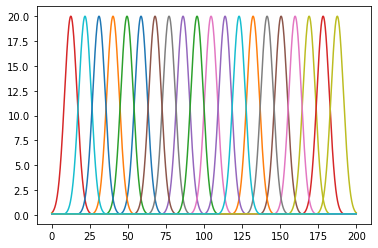

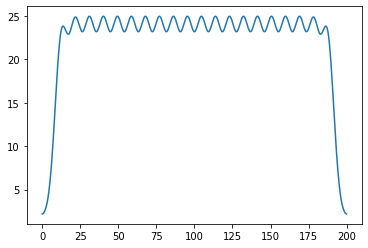

In [6]:
fr = ar.cell_information['LEC']['cell info'][0]['firing rate']

edge = 12.5
nlaps = 20
lp    = 1

arena_map  = np.arange(0, 200,step=0.1)
cued_positions  = np.linspace(edge, 200-edge, nlaps*lp)
random_cue_locs = np.arange(len(cued_positions))
np.random.shuffle(random_cue_locs)

frs_all = []
for i in range(nlaps):
    random_position = cued_positions[random_cue_locs[i]]
    to_roll = int( ( 100. - random_position) / 0.1 )
    fr_rolled = np.roll(fr, to_roll)
    frs_all.append(fr_rolled)

frs_all = np.asarray(frs_all)

plt.figure()
for i in range(nlaps):
    plt.plot(arena_map, frs_all[i])
    
plt.figure()
plt.plot(arena_map,np.sum(frs_all, axis=0))

plt.show();

In [7]:
arena_size = ar.params['Arena']['arena size']
bin_size   = ar.params['Arena']['bin size']
mouse_speed = ar.params['Arena']['mouse speed']
nlaps       = ar.params['Arena']['lap information']['nlaps']

time_for_single_lap = arena_size / mouse_speed * 1000.
print(time_for_single_lap, nlaps)

6666.666666666667 25


In [13]:
place_information = {'place ids': [0], 'place fracs': [0.80]}

diagram = WiringDiagram(os.path.join(params_path, circuit_config_name), 
                        place_information)
internal_kwargs = {}
internal_kwargs['place information'] = diagram.place_information
internal_kwargs['cue information'] = diagram.place_information
diagram.generate_internal_connectivity(**internal_kwargs)

place_ids = diagram.place_information[0]['place']
cue_ids = diagram.place_information[0]['not place']

print(list(diagram.place_information.keys()))
external_kwargs = {}
external_kwargs['place information'] = diagram.place_information
external_kwargs['external place ids'] = [100, 101, 102]
external_kwargs['cue information'] = diagram.place_information
external_kwargs['external cue ids'] = [100, 101, 102]

diagram.generate_external_connectivity(ar.cell_information, **external_kwargs)

diagram.generate_septal_connectivity()




[0]


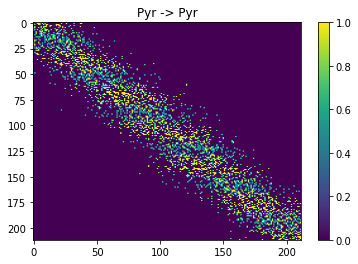

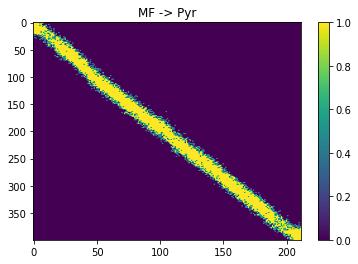

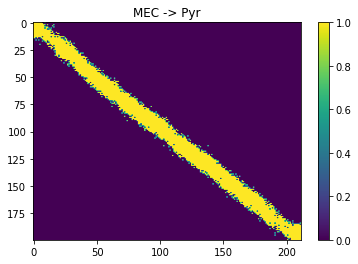

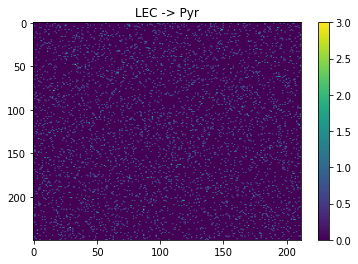

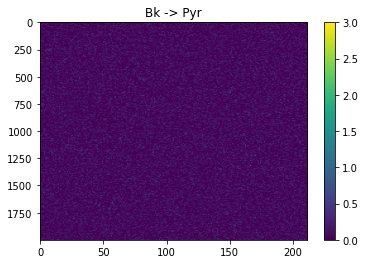

5005
7904
25200


In [14]:
plt.figure()
plt.title("Pyr -> Pyr")
plt.imshow(diagram.internal_adj_matrices[0][0][place_ids,:][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.title("MF -> Pyr")
plt.imshow(diagram.external_adj_matrices[100][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.title("MEC -> Pyr")
plt.imshow(diagram.external_adj_matrices[101][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.title("LEC -> Pyr")
plt.imshow(diagram.external_adj_matrices[102][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.title("Bk -> Pyr")

plt.imshow(diagram.external_adj_matrices[103][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

print(np.sum(diagram.internal_adj_matrices[0][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][1],axis=0).sum())


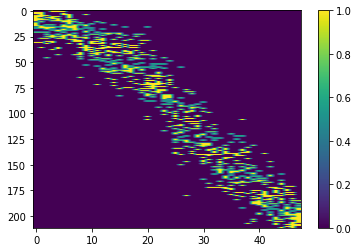

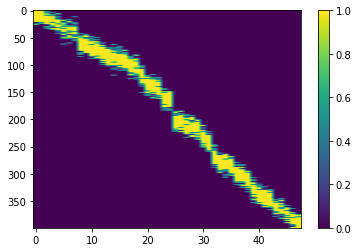

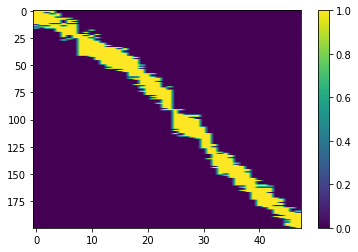

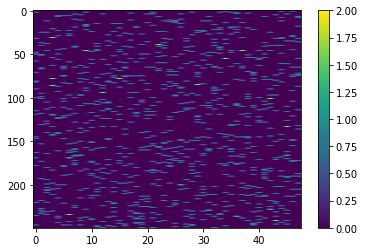

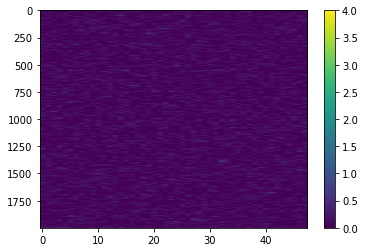

5005
7904
25200


In [15]:
plt.figure()
plt.imshow(diagram.internal_adj_matrices[0][0][place_ids,:][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(diagram.external_adj_matrices[100][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[101][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[102][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[103][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

print(np.sum(diagram.internal_adj_matrices[0][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][1],axis=0).sum())


In [16]:
def pull_spike_times(population2info_dict):
    spike_times = {}
    gids = np.sort(list(population2info_dict.keys()))
    for gid in gids:
        spike_times[gid] = population2info_dict[gid]['spike times']
    return spike_times

mf_spike_times  = pull_spike_times(ar.cell_information['MF']['cell info'])
mec_spike_times = pull_spike_times(ar.cell_information['MEC']['cell info'])
lec_spike_times = pull_spike_times(ar.cell_information['LEC']['cell info'])
bk_spike_times  = pull_spike_times(ar.cell_information['Background']['cell info'])

z = 28
MF src ids: [19 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 58 59]


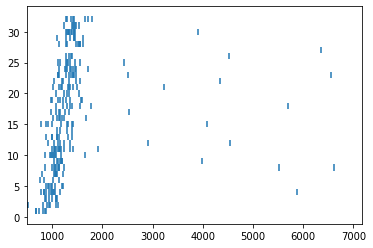

MEC src ids: [10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 32]


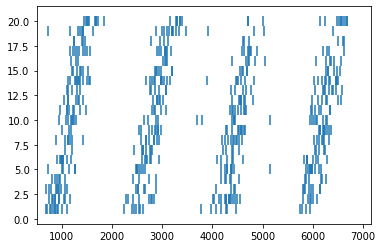

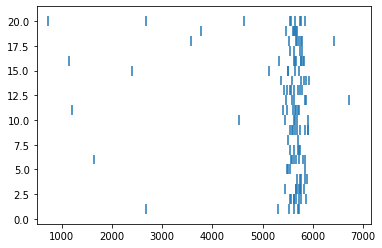

In [17]:
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500

place_cells = diagram.place_information[0]['place']

ctype_offset = diagram.external_information['MF']['ctype offset']
for z in place_cells[20:21]:

    print(f"z = {z}")
    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][:,z])[0]
    print(f"MF src ids: {src_ids}")
    i = 0
    for src_id in src_ids:
        
        src_gid = src_id # + ctype_offset
        if src_gid not in mf_spike_times:
            continue
            
        src_gid_spikes = mf_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    

ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][:,z])[0]
    print(f"MEC src ids: {src_ids}")
    i = 0
    for src_id in src_ids:
        src_gid = src_id # + ctype_offset
        if src_gid not in mec_spike_times:
            continue
        src_gid_spikes = mec_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id # + ctype_offset
        if src_gid not in lec_spike_times:
            continue
        src_gid_spikes = lec_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    


In [20]:
ext_spike_times = np.load(f"../data/ext_spikes_{run_name}-cue-ee-ei-nlaps-{nlaps}.npz")
ext_spike_times = { int(k): v for k,v in ext_spike_times.items() }

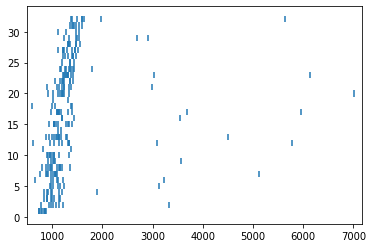

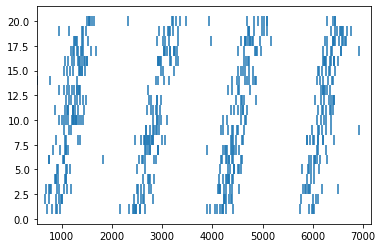

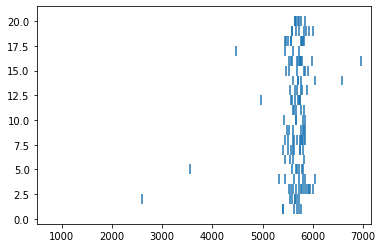

In [21]:
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500

place_cells = diagram.place_information[0]['place']

ctype_offset = diagram.external_information['MF']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
            
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    

ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    


[2, 3, 9, 12, 16, 22, 23, 24, 40, 41, 44, 47, 52, 55, 57, 58, 59, 67, 68, 79, 88, 90, 94, 106, 107, 132, 134, 137, 139, 141, 152, 158, 174, 182, 183, 185, 196, 198, 203, 214, 220, 223, 226, 234, 237, 243, 250, 254]


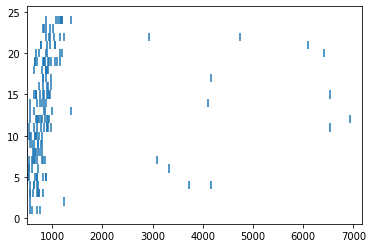

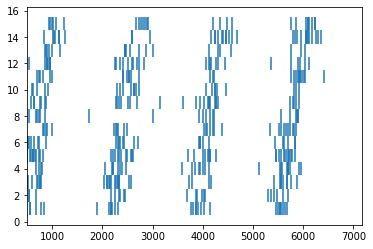

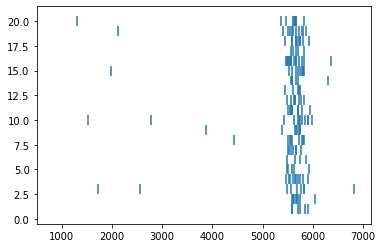

In [18]:
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500

cue_cells = diagram.place_information[0]['not place']
print(cue_cells)

ctype_offset = diagram.external_information['MF']['ctype offset']

for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid in ext_spike_times:
            src_gid_spikes = ext_spike_times[src_gid]
            if len(src_gid_spikes) > 0:
                src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                       src_gid_spikes <= finish))]
                plt.vlines(list(src_spikes), i+0.5, i+1.5)
                i += 1
plt.xlim([start, finish])
plt.show();
    

ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    

    


[2, 3, 9, 12, 16, 22, 23, 24, 40, 41, 44, 47, 52, 55, 57, 58, 59, 67, 68, 79, 88, 90, 94, 106, 107, 132, 134, 137, 139, 141, 152, 158, 174, 182, 183, 185, 196, 198, 203, 214, 220, 223, 226, 234, 237, 243, 250, 254]


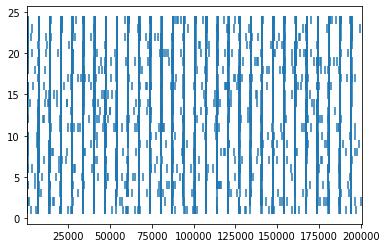

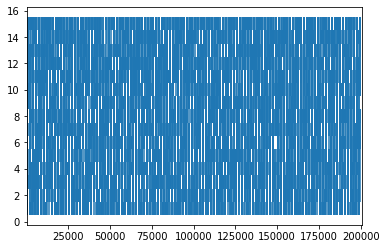

In [22]:
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 30 + 500

cue_cells = diagram.place_information[0]['not place']
print(cue_cells)

ctype_offset = diagram.external_information['MF']['ctype offset']

for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid in ext_spike_times:
            src_gid_spikes = ext_spike_times[src_gid]
            if len(src_gid_spikes) > 0:
                src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                       src_gid_spikes < finish))]
                plt.vlines(list(src_spikes), i+0.5, i+1.5)
                i += 1
plt.xlim([start, finish])
plt.show();
    

ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes < finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    
  


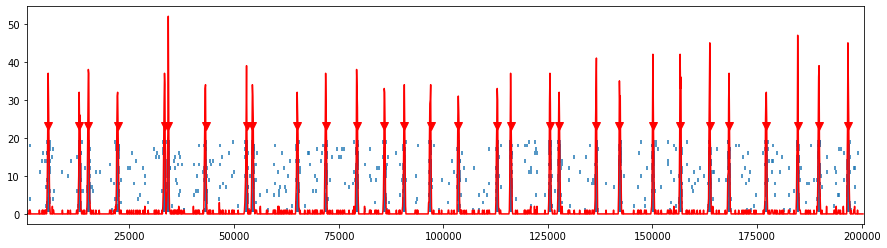

(30,)
[  5600.  13000.  15200.  22200.  33400.  34300.  43200.  53000.  54400.
  65100.  71900.  79300.  85900.  90700.  97000. 103600. 112900. 116100.
 125500. 127700. 136600. 142100. 150100. 156600. 163700. 168300. 177200.
 184700. 189800. 196700.]


In [23]:
from scipy.signal import find_peaks
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 30 + 500


hist_bins = np.arange(start, finish, 100)
lec_histogram = None
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in cue_cells[2:3]:

    plt.figure(figsize=(15,4))
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes < finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            src_nspikes, bin_edges = np.histogram(src_spikes, bins=hist_bins)
            if lec_histogram is None:
                lec_histogram = src_nspikes
            else:
                lec_histogram += src_nspikes

            i += 1
    plt.plot(bin_edges[:-1], lec_histogram, color='r')

event_indices, _ = find_peaks(lec_histogram, height=25, width=2)
event_times = bin_edges[event_indices]
event_y = np.ones(len(event_times)) * (len(src_ids) + 4)
plt.plot(event_times, event_y, marker='v', color='r', markersize=8, linestyle='none',)

plt.xlim([start, finish])
plt.show();

print(event_times.shape)
print(event_times)

In [26]:
exc_v_vecs = { int(k): v for k,v in np.load(f"../data/v_vecs_{run_name}-cue-ee-ei-nlaps-{nlaps}.npz").items() }
dt = 0.025
t_end = exc_v_vecs[0].shape[0] * dt*4
t_vec = np.arange(0., t_end, dt*4)

In [27]:
t_end

200499.0

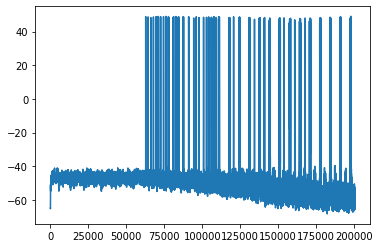

In [28]:
exc_v_vec_150 = exc_v_vecs[150]
plt.plot(t_vec, exc_v_vec_150)
plt.show();

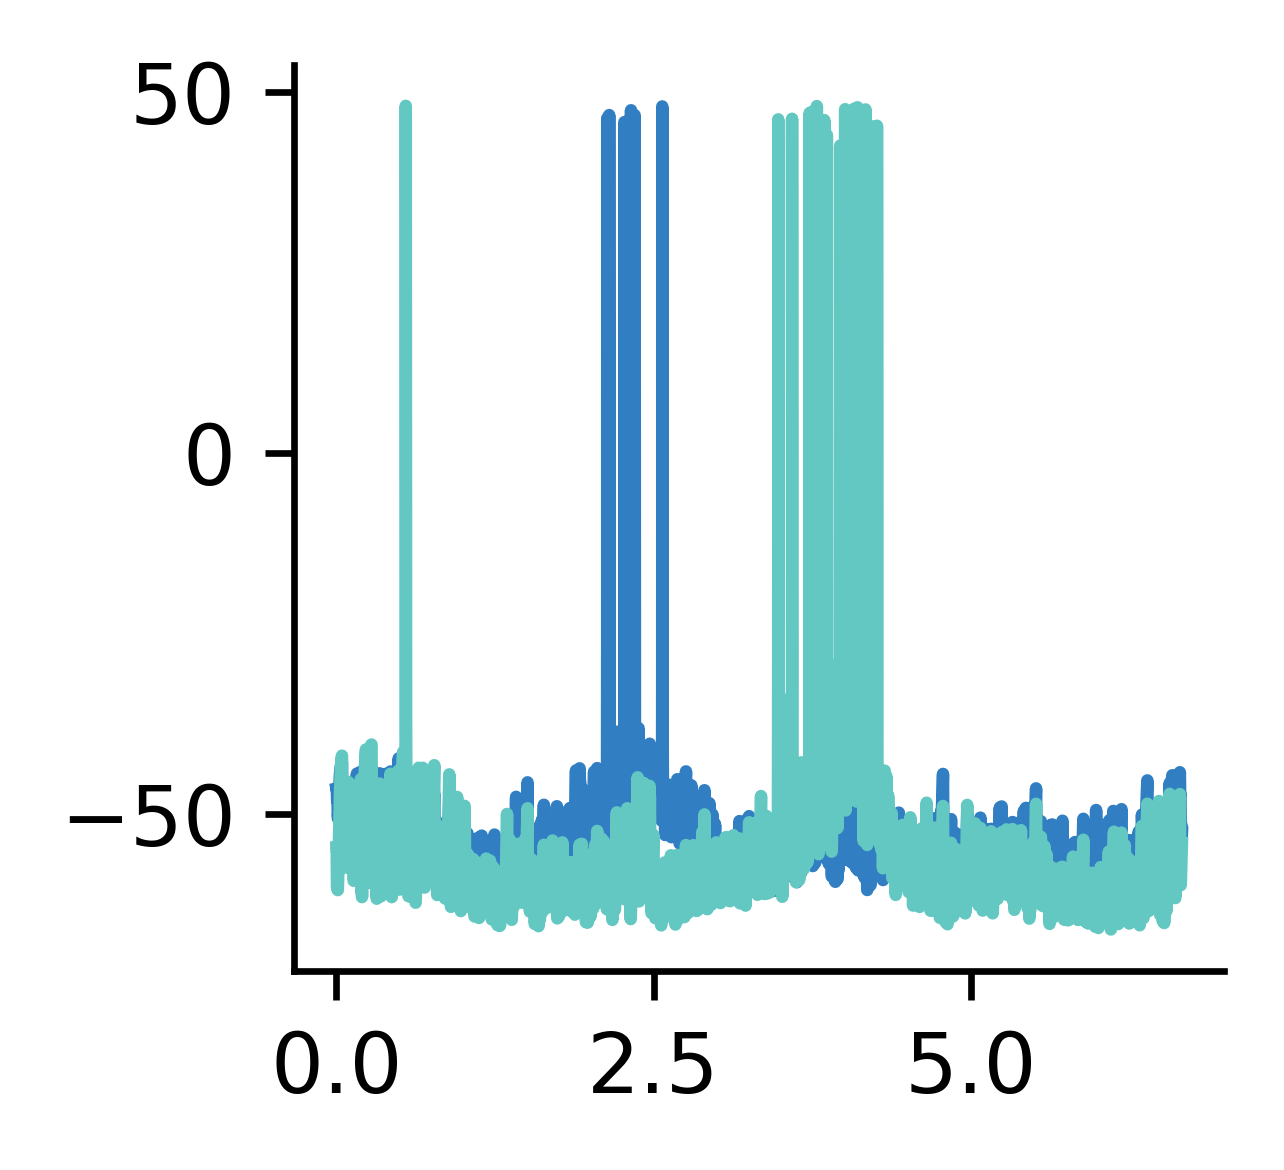

In [29]:
s = np.where(t_vec > time_for_single_lap*25+500)[0][0]
e = np.where(t_vec < time_for_single_lap*26+500)[0][-1]

# plt.figure()
# plt.plot(t_vec[s:e], list(exc_v_vecs[65])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[66])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[64])[s:e], color='k')
# plt.plot(t_vec[s:e], list(pvbc_v_vecs[0])[s:e], color='r')
# plt.show()

fig = plt.figure(figsize=(2,2), dpi=600)
ax  = fig.gca()
plt.plot( (t_vec[s:e]-t_vec[s])/1000., exc_v_vecs[83][s:e], color=(49/255., 126/255., 194/255.))
plt.plot( (t_vec[s:e]-t_vec[s])/1000., exc_v_vecs[150][s:e], color=(100/255., 200/255., 194/255.))
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show();

In [32]:
saved_weights = restore_weights(diagram, f"../params/{run_name}-cue-ee-ei-nlaps-{saved_weight_nlaps}-dt-zerodot1-scale-2-v1.npz")

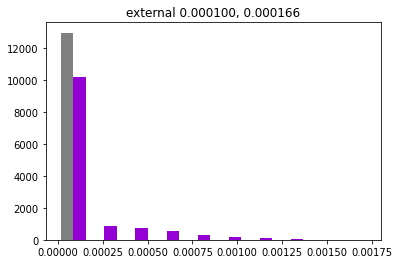

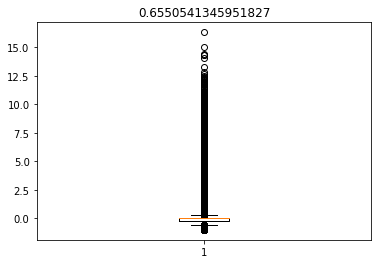

In [33]:
external_before, external_after, external_pchange = saved_weight_change(saved_weights, 100, 0,
                                                                       valid_gids=set(place_cells))
external_pchange = np.asarray(external_pchange)

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#



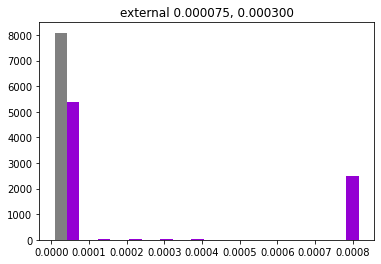

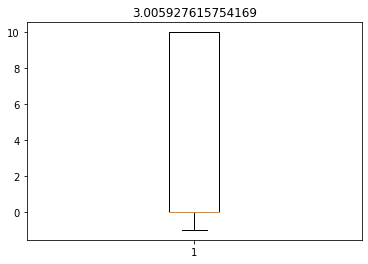

In [34]:
external_before, external_after, external_pchange = saved_weight_change(saved_weights, 101, 0,
                                                                       valid_gids=set(place_cells))
external_pchange = np.asarray(external_pchange)

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#



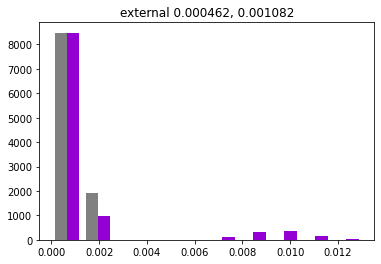

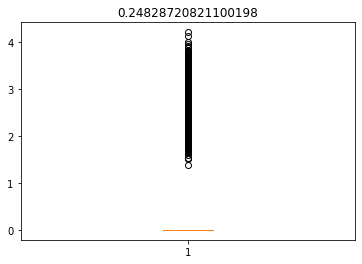

In [35]:
external_before, external_after, external_pchange = saved_weight_change(saved_weights, 102, 0)
external_pchange = np.asarray(external_pchange)

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#



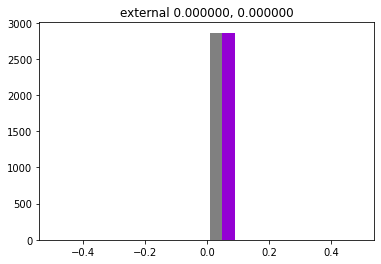

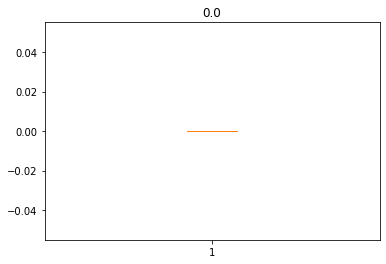

In [36]:
place_cells = diagram.place_information[0]['place']
non_place_cells = diagram.place_information[0]['not place']


external_before, external_after, external_pchange = saved_weight_change(saved_weights, 100, 0, valid_gids=non_place_cells)
external_pchange = np.asarray(external_pchange)

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#



0.01425


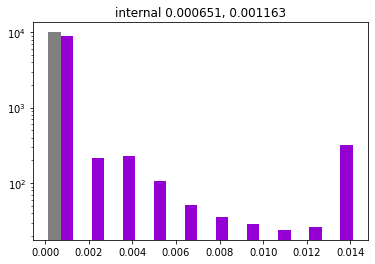

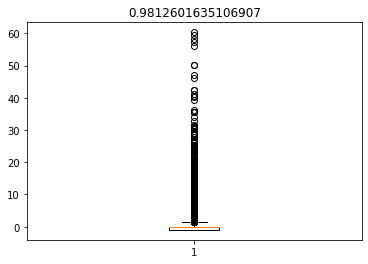

internal 0
0.0054


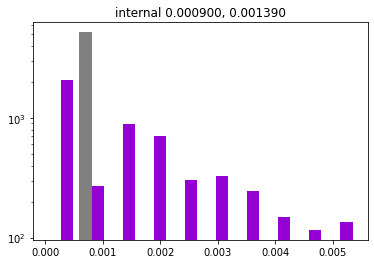

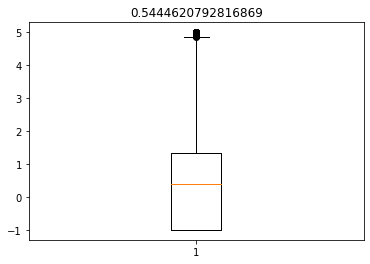

In [37]:
scale = 2

internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 0, 0)
                                                                        
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

print('internal', len(np.where(np.asarray(internal_after) >= 0.025)[0]))

#

internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 1, 0)
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

0.01425


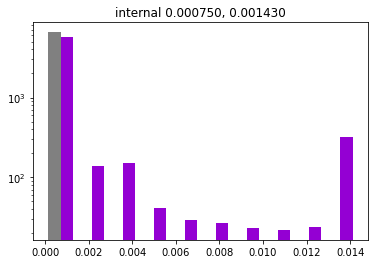

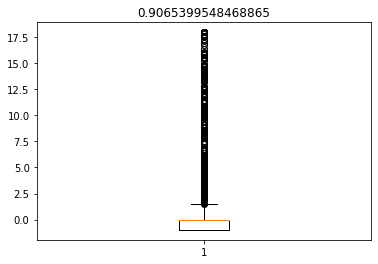

internal 0


In [38]:
scale = 2
internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 0, 0, valid_gids=place_cells,  
                                                                        valid_src_gids=set(place_cells))
#place_cells)
                                                                        
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

print('internal', len(np.where(np.asarray(internal_after) >= 0.025)[0]))

#



0.013802265


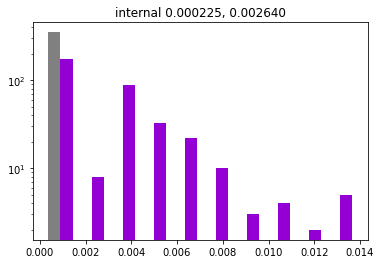

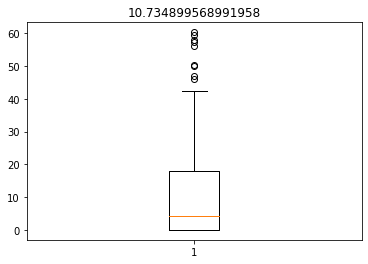

internal 0


In [39]:
scale = 2
internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 0, 0, valid_gids=non_place_cells, 
                                                                        valid_src_gids=set(non_place_cells))
#place_cells)
                                                                        
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

print('internal', len(np.where(np.asarray(internal_after) >= 0.025)[0]))

#



0.013004654


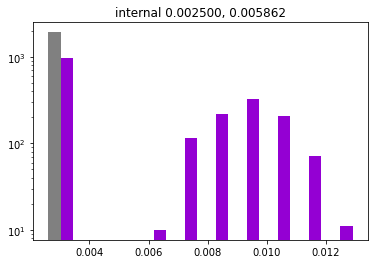

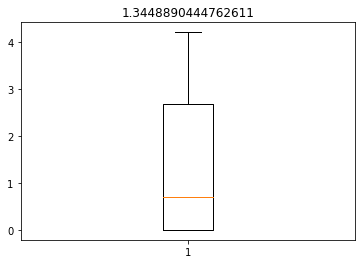

In [40]:
internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 102, 0, 
                                                                        valid_gids=set(cue_ids))
#non_place_cells)
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

5200
place median 0.0015207472
nonplace median 0.0023800002
place mean 0.0022633886
nonplace mean 0.0024076228
place sum 9.596767
nonplace sum 2.311318
place max 0.0063
nonplace max 0.0033624247
-2.849462468551282 0.0043965391434903954
1623902.0 3.874445528583519e-23


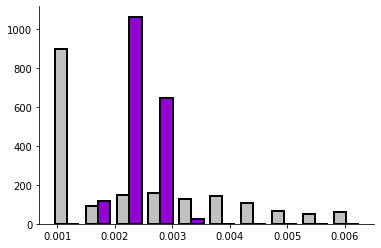

In [41]:
place_cells = diagram.place_information[0]['place']
non_place_cells = diagram.place_information[0]['not place']
scale = 2

pvbc_to_place_weights = []
for pgid in place_cells:
    cell_info = saved_weights[0][pgid]
    src_gids, connection_weights, connection_weights_upd, _ = cell_info[1]
    pvbc_inds = np.argwhere(np.logical_and(src_gids >= 130*2, src_gids < 130*2 + 30))[:,0]
    weights = connection_weights[pvbc_inds] + connection_weights_upd[pvbc_inds]
    pvbc_to_place_weights.append(weights)

pvbc_to_place_weights = np.concatenate(pvbc_to_place_weights)            
            
pvbc_to_notplace_weights = []
for pgid in non_place_cells:
    cell_info = saved_weights[0][pgid]
    src_gids, connection_weights, connection_weights_upd, _ = cell_info[1]
    pvbc_inds = np.argwhere(np.logical_and(src_gids >= 130*2, src_gids < 130*2 + 30))[:,0]
    
    weights = connection_weights[pvbc_inds] + connection_weights_upd[pvbc_inds]
    pvbc_to_notplace_weights.append(weights)
            
pvbc_to_notplace_weights = np.concatenate(pvbc_to_notplace_weights)            
            
print(len(pvbc_to_place_weights) + len(pvbc_to_notplace_weights))
        
fig = plt.figure()
ax  = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=['silver', 'darkviolet'], 
         density=True, edgecolor='k', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

print('place mean', np.mean(pvbc_to_place_weights))
print('nonplace mean', np.mean(pvbc_to_notplace_weights))

print('place sum', np.sum(pvbc_to_place_weights))
print('nonplace sum', np.sum(pvbc_to_notplace_weights))

print('place max', np.max(pvbc_to_place_weights))
print('nonplace max', np.max(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind, mannwhitneyu
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)

u, p2 = mannwhitneyu(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(u, p2)

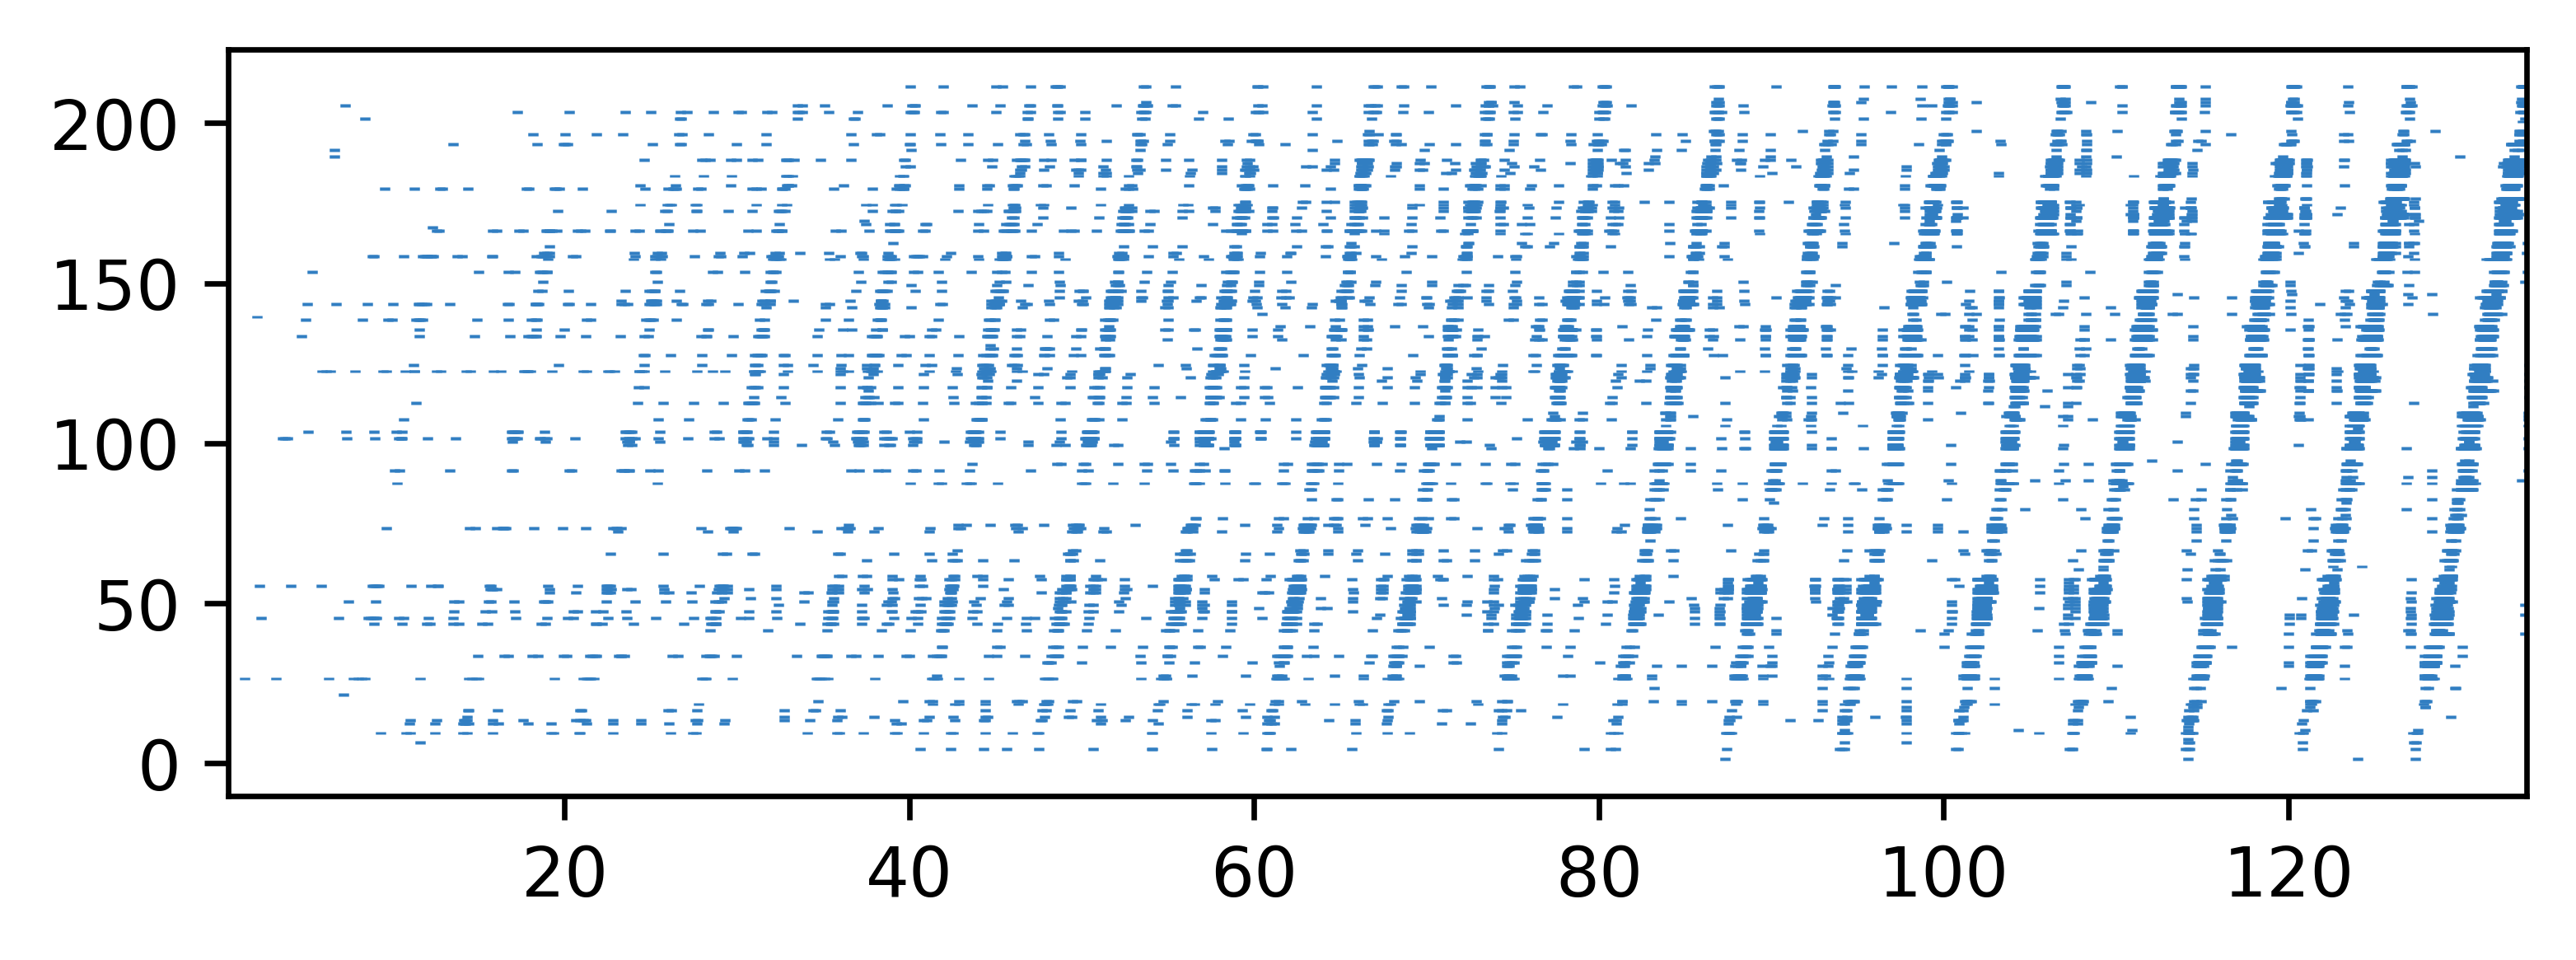

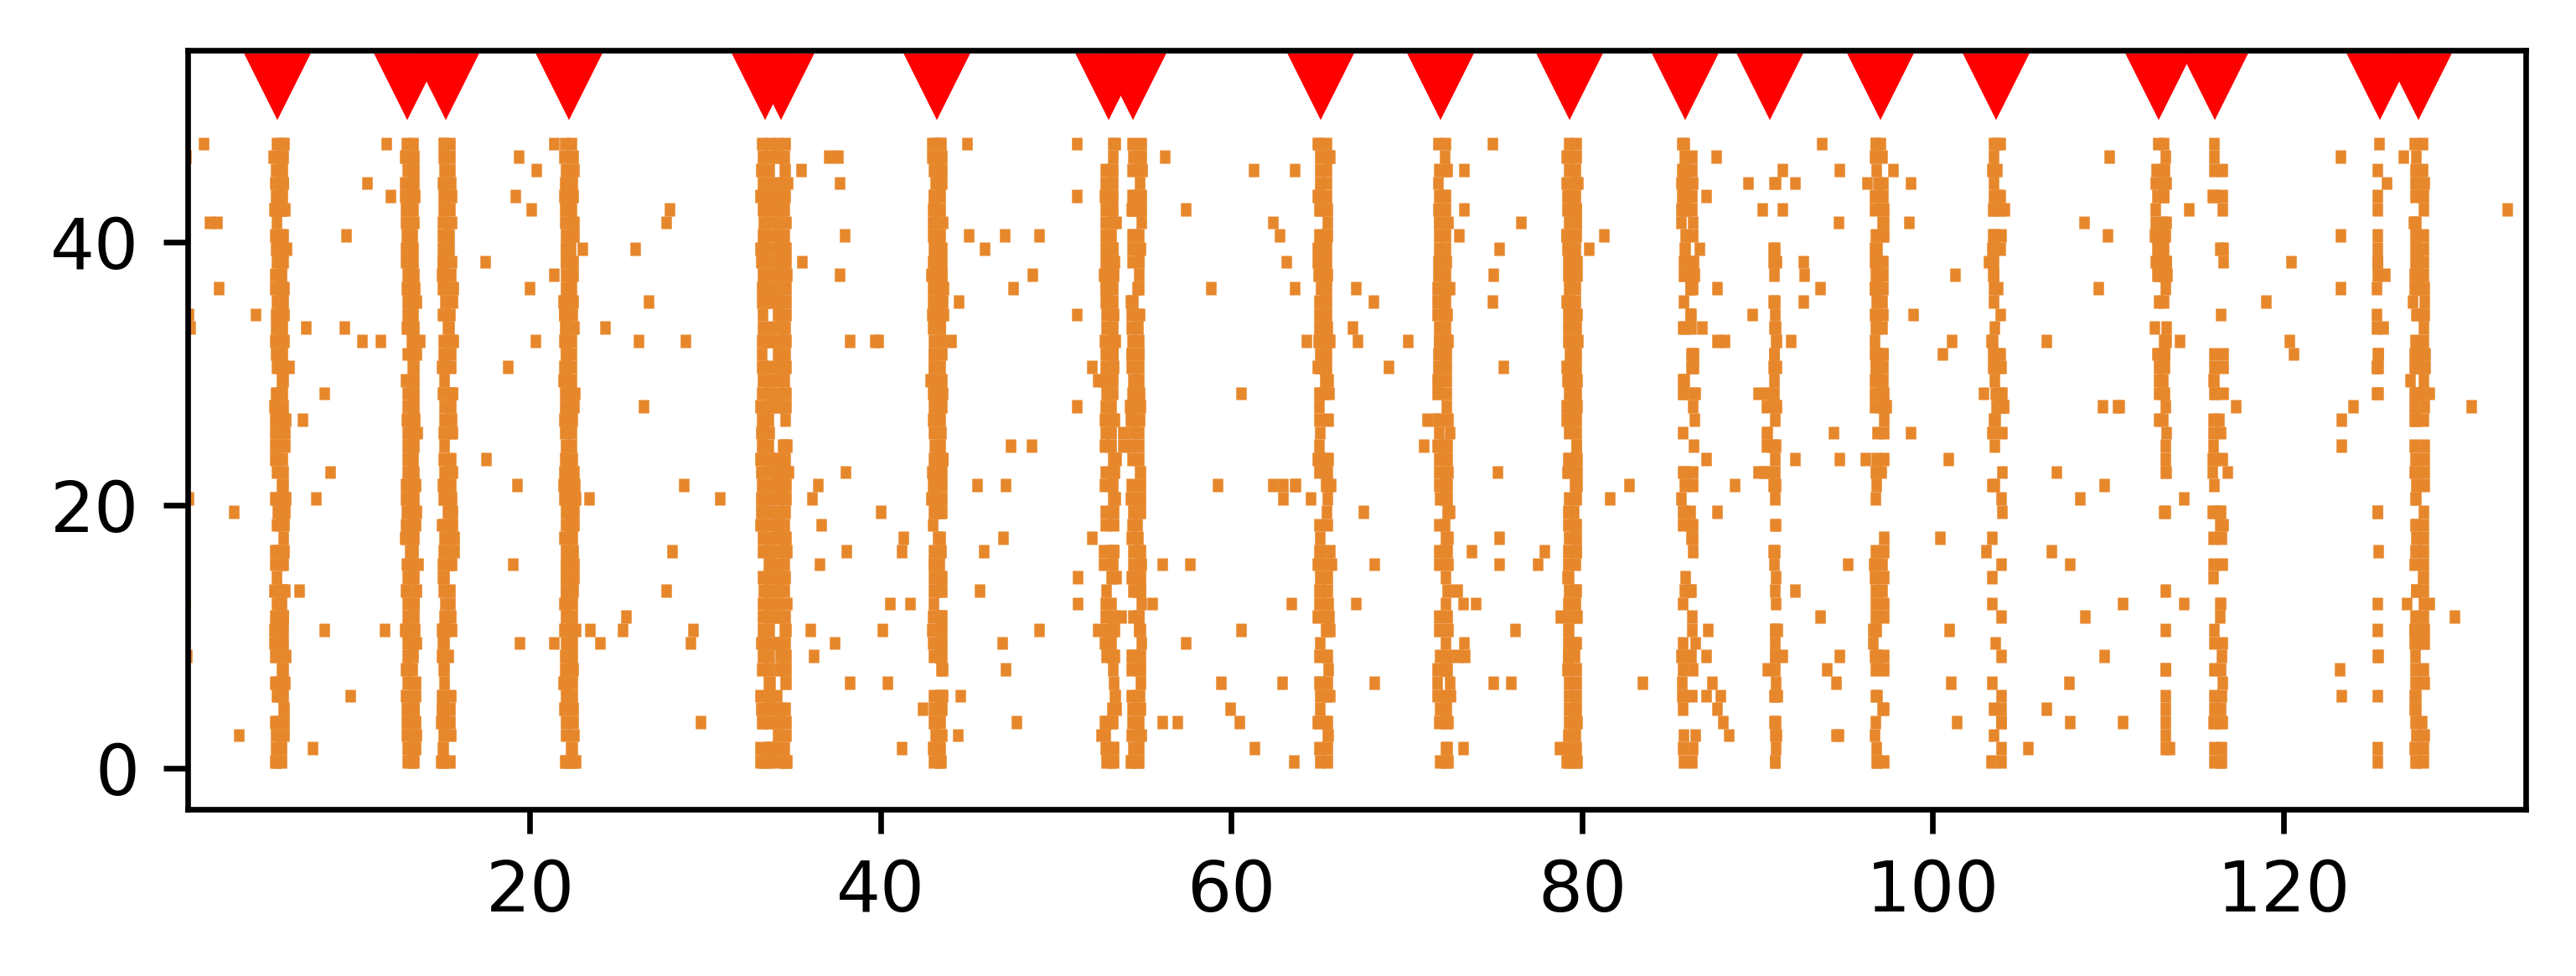

In [42]:
cell_spike_times = np.load(f"../data/cell_spikes_{run_name}-cue-ee-ei-nlaps-{nlaps}.npz")

cell_spike_times = { int(gid): v for gid, v in cell_spike_times.items() }
start  = time_for_single_lap * 0. + 500
finish = time_for_single_lap * saved_weight_nlaps + 500

plot_spikes(cell_spike_times, 'PYR place', start, finish, 
            gids=diagram.place_information[0]['place'], 
            colors=(49/255.,126/255.,194/255.))
plot_spikes(cell_spike_times, 'PYR cue', start, finish, 
            gids=diagram.place_information[0]['not place'], 
            colors=(231/255.,135/255.,43/255.), 
            events=event_times / 1000.)


#plot_spikes(circuit, 0, 'PYR all', start, finish, gids=np.arange(130*2))
#plot_spikes(circuit, 1, 'PVBC', start, finish, gids=None)

    

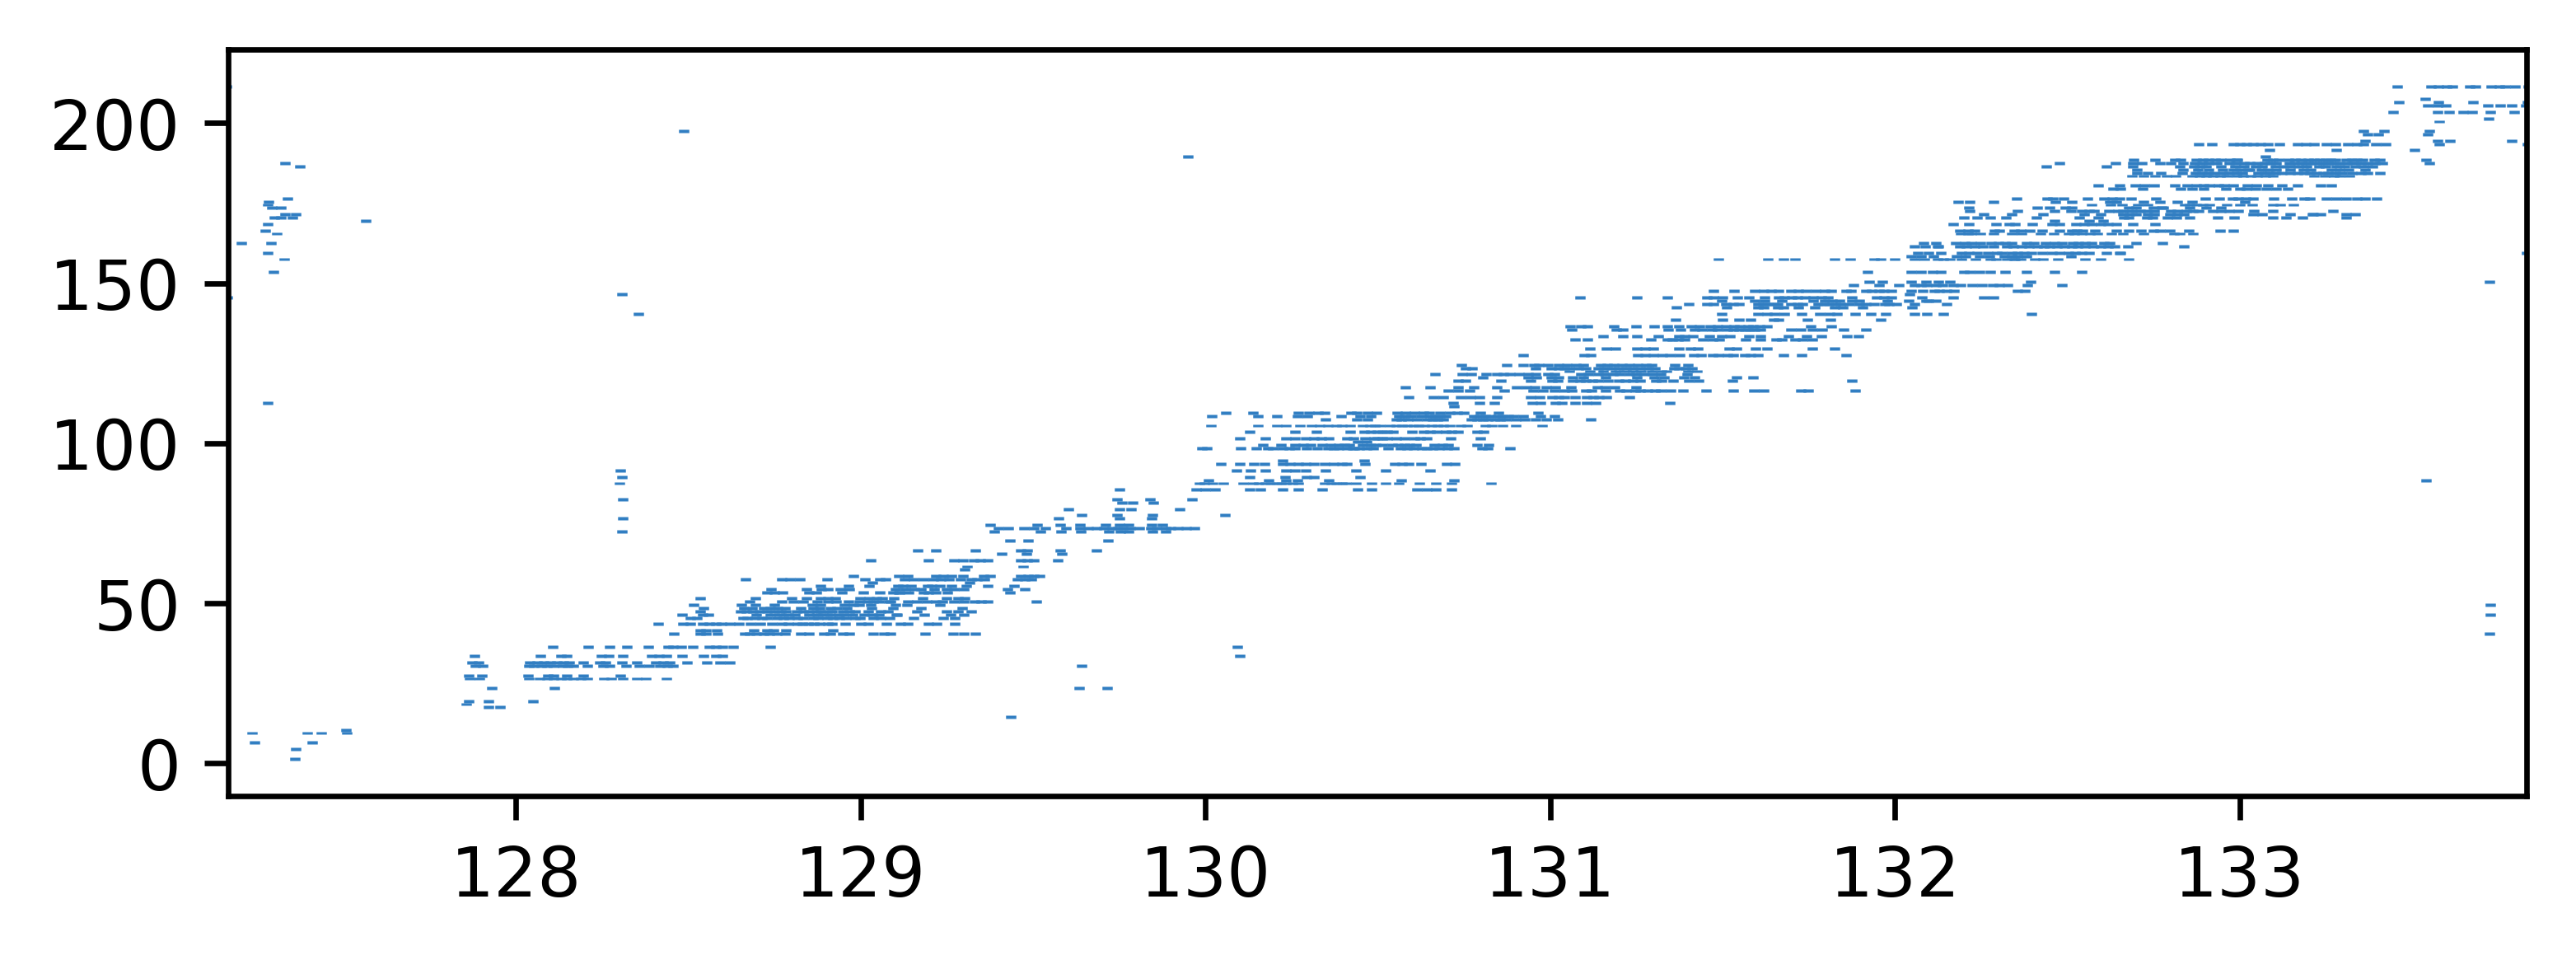

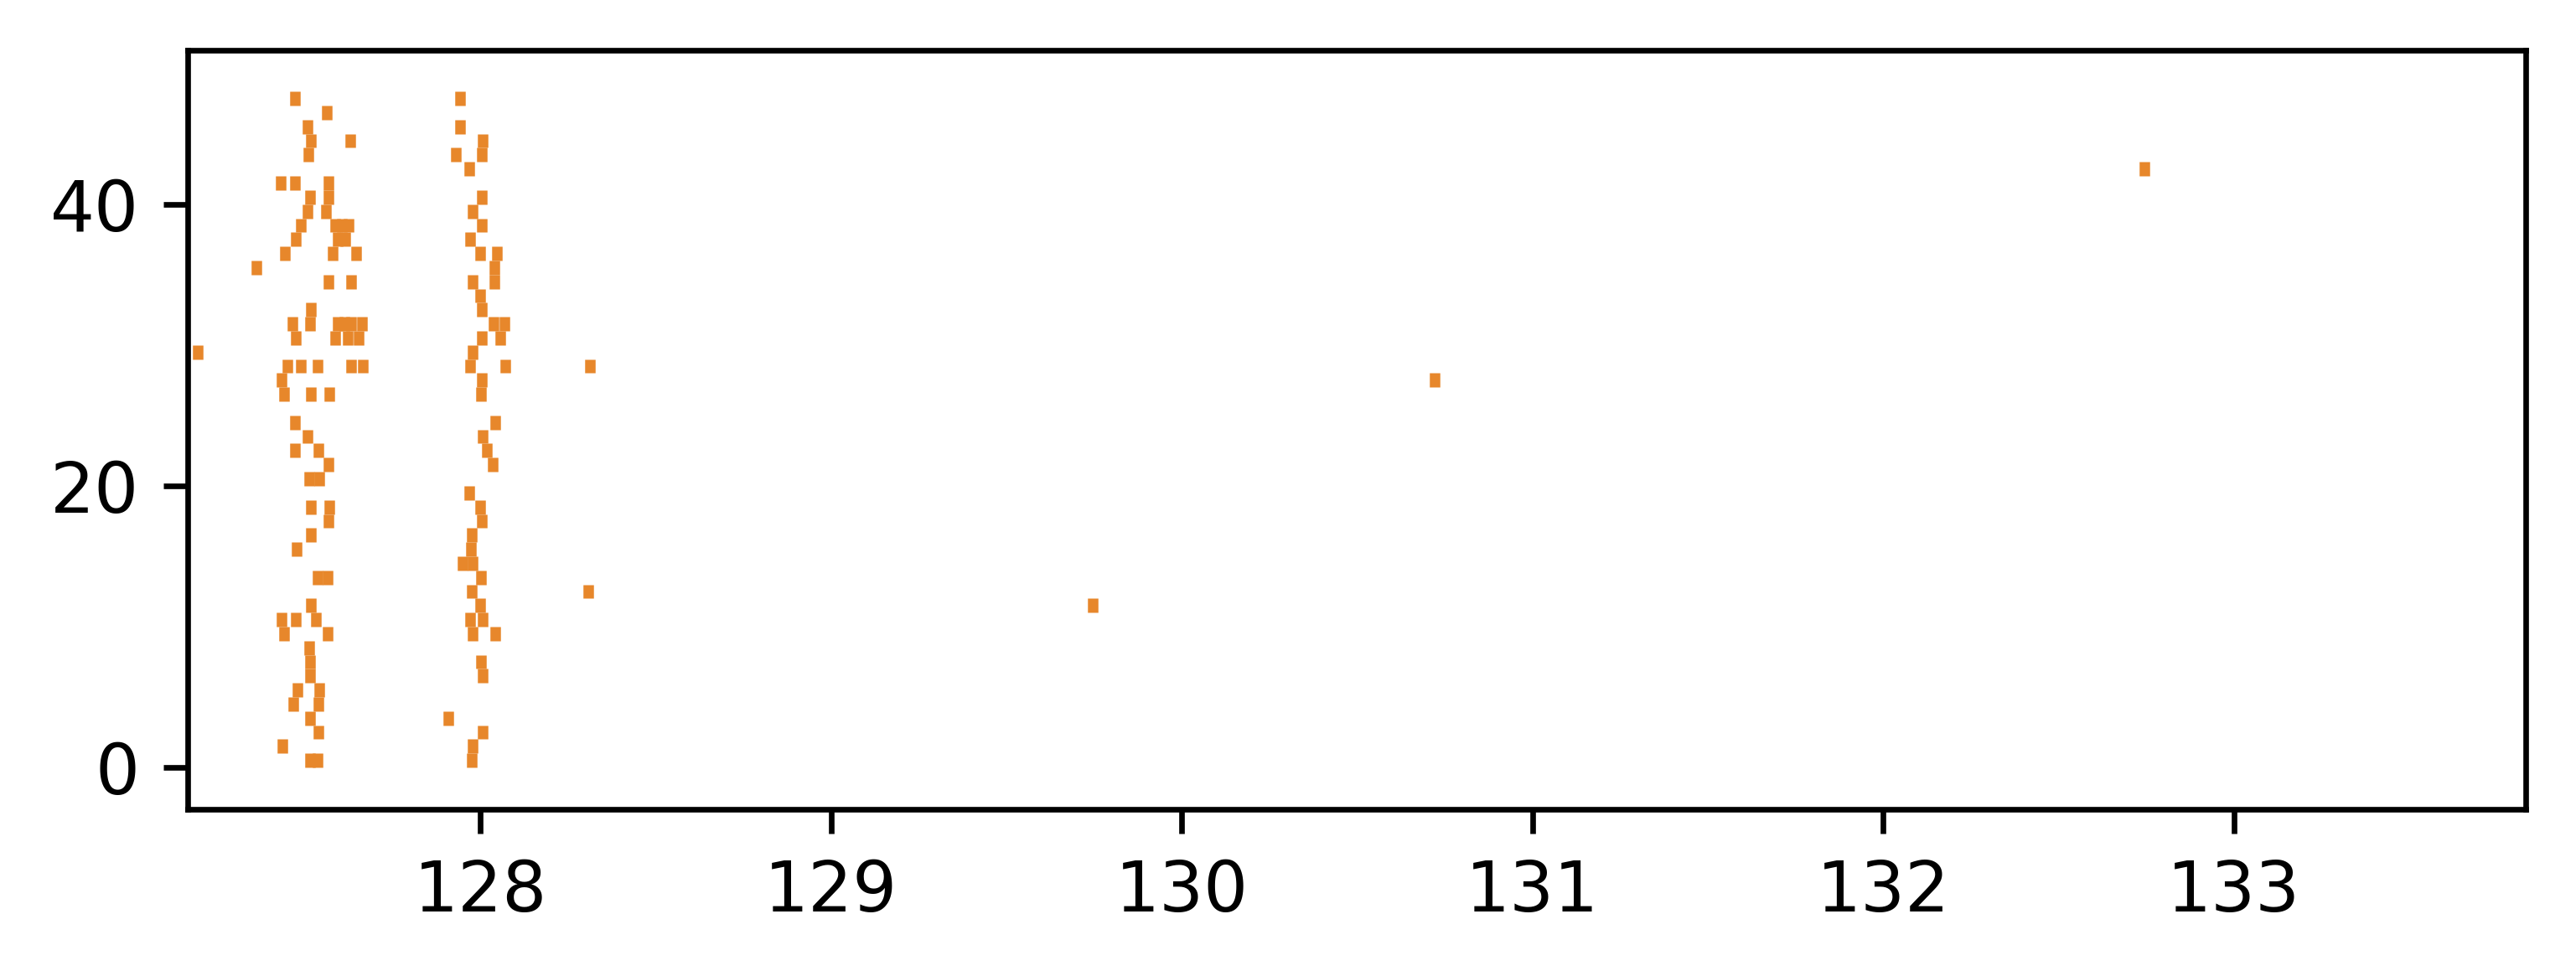

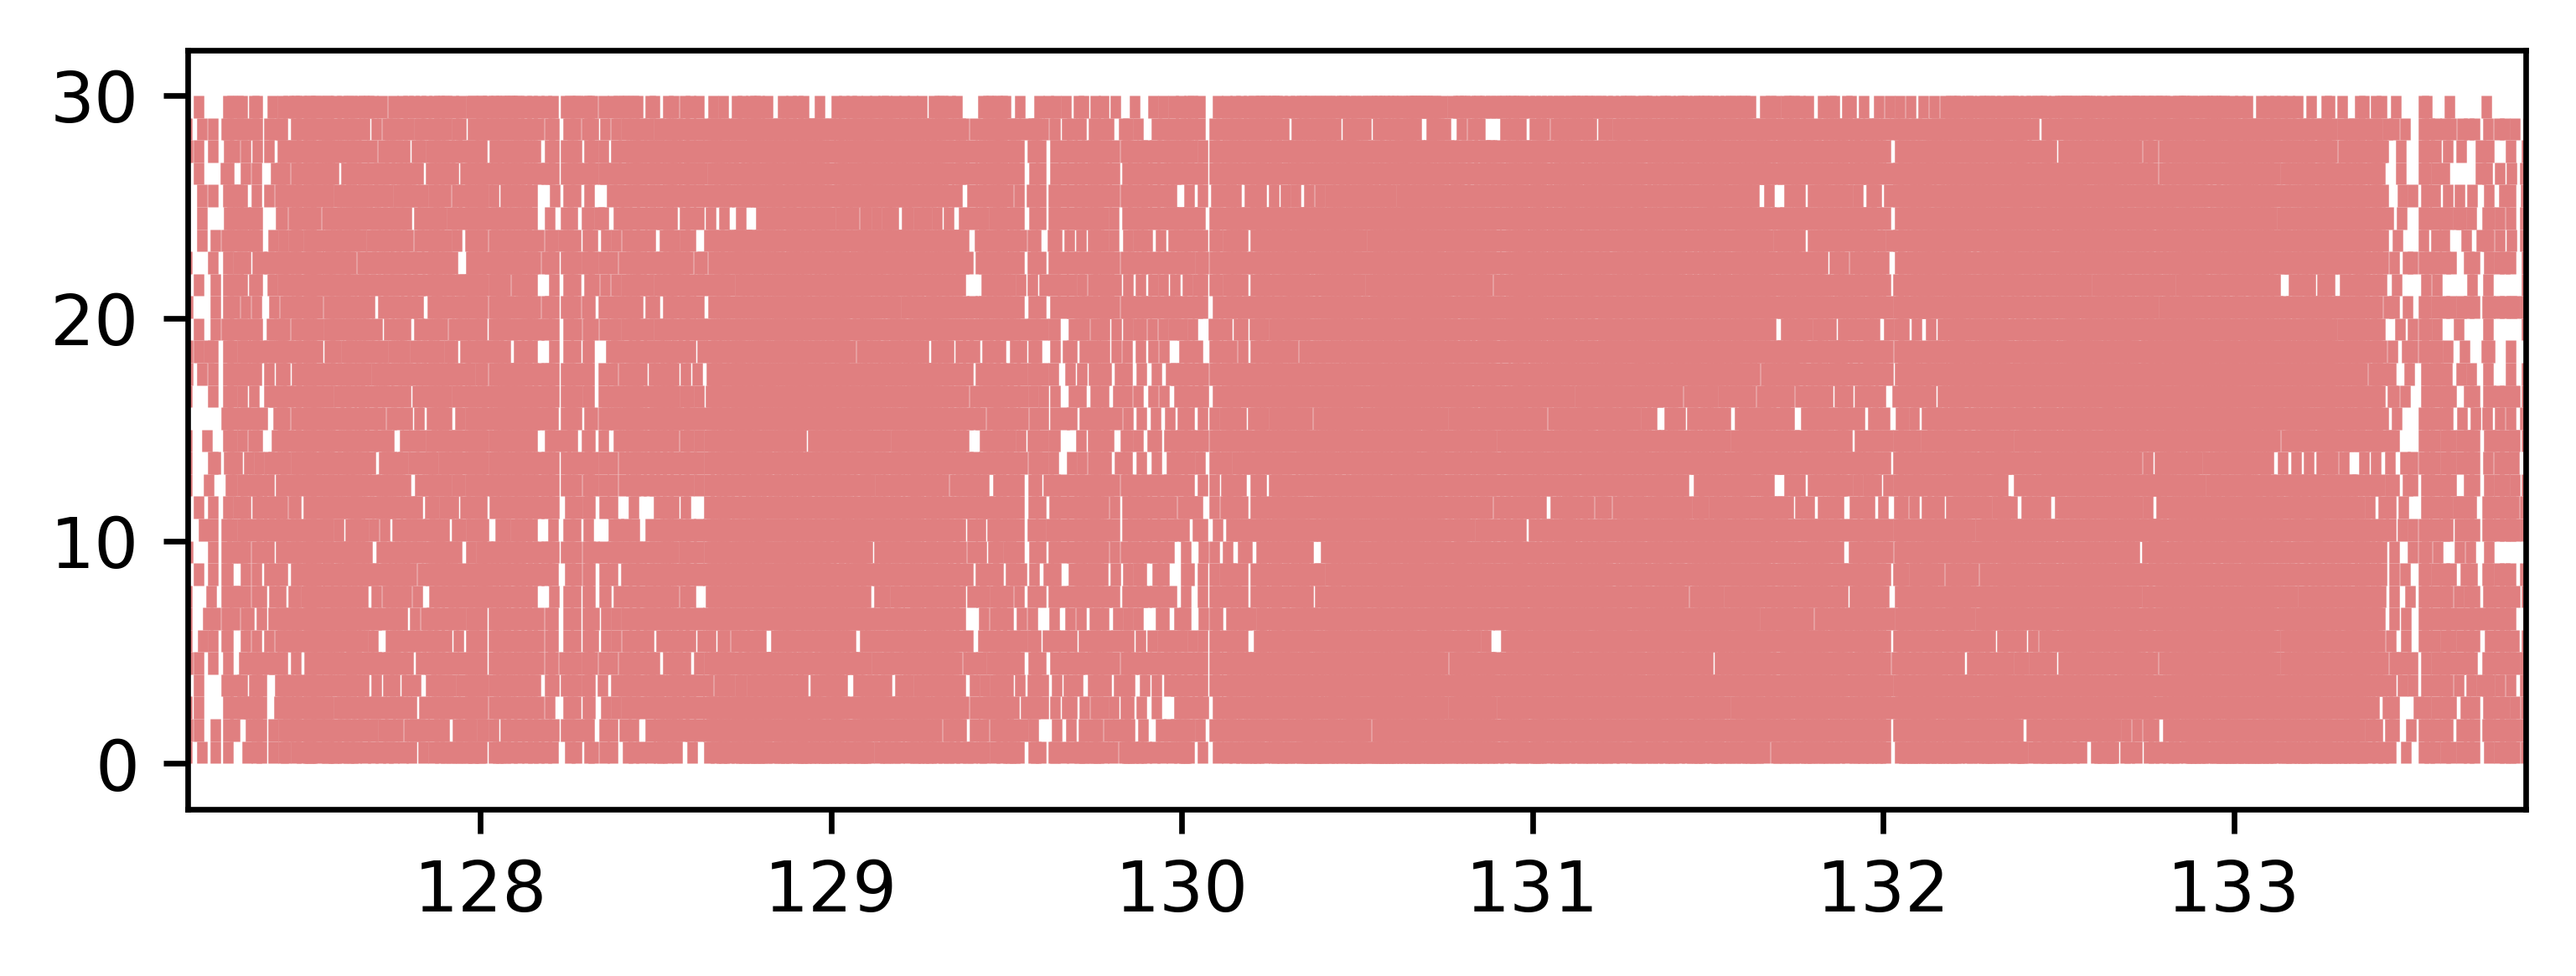

In [43]:
start  = time_for_single_lap * (saved_weight_nlaps-1) + 500
finish = time_for_single_lap * saved_weight_nlaps + 500

plot_spikes(cell_spike_times, 'PYR place', start, finish, 
            gids=diagram.place_information[0]['place'], colors=(49/255.,126/255.,194/255.))
plot_spikes(cell_spike_times, 'PYR cue', start, finish, 
            gids=diagram.place_information[0]['not place'], colors=(231/255.,135/255.,43/255.))
#plot_spikes(circuit, 0, 'PYR all', start, finish, gids=np.arange(130))
plot_spikes(cell_spike_times, 'PVBC', start, finish, 
            gids=np.arange(130*2, 130*2 + 30), colors=(224/255.,127/255., 128/255.))

#plot_spikes(circuit, 1, 'PVBC', start, finish, gids=np.arange(130,145))

# plot_spikes(circuit, 2, 'AAC', start, finish)
# plot_spikes(circuit, 3, 'BiS', start, finish)
# plot_spikes(circuit, 4, 'OLM', start, finish)
# plot_spikes(circuit, 5, 'ISCCR', start, finish)
    

4.027851999367258 7.408223565839533e-05


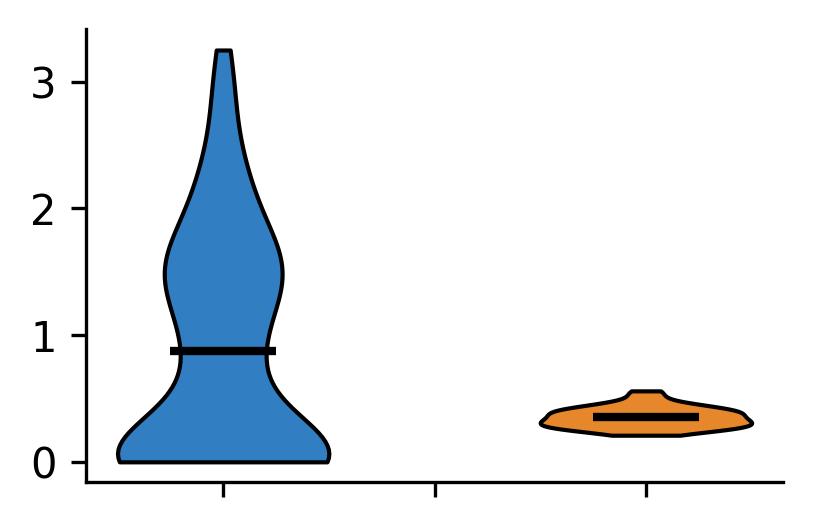

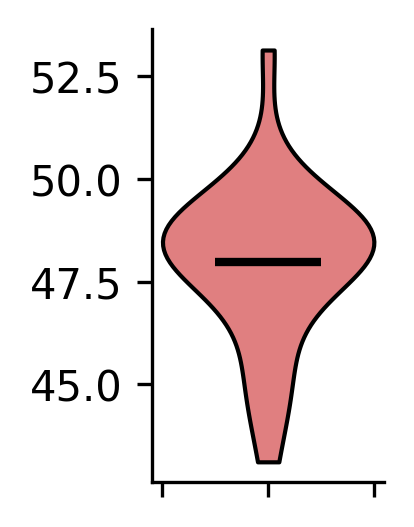

In [44]:
from scipy.stats import ttest_ind

def get_pop_frs(spike_times, title, start, finish, gids=None, color='k'):
    
    frs = []
    for (gid,sts) in spike_times.items():
        if gid not in gids:
            continue
        sts = np.divide(np.asarray(sts), 1000.)
        sts_chop = sts[np.where( (sts>=start/1000.) & (sts<=finish/1000.)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
        
    return frs

start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 30 + 500

colors = [(49/255.,126/255.,194/255.), (231/255.,135/255.,43/255.), (224/255.,127/255., 128/255.)]

place_frs = get_pop_frs(cell_spike_times, 'PYR place', start, finish, gids=diagram.place_information[0]['place'], color=(49/255.,126/255.,194/255.))
cue_frs   = get_pop_frs(cell_spike_times, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'], color=(231/255.,135/255.,43/255.))
int_frs   = get_pop_frs(cell_spike_times, 'PVBC', start, finish, gids=np.arange(130*2,130*2 + 30))

t, p = ttest_ind(place_frs, cue_frs)
print(t,p)

fig = plt.figure(dpi=300, figsize=(3,2))
ax = fig.gca()
vplot = plt.violinplot([place_frs, cue_frs], showextrema=False, showmeans=True, positions=[0,1])
ax.set_xticklabels([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

for (i,pc) in enumerate(vplot['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)

vp = vplot['cmeans']
vp.set_edgecolor('black')
vp.set_linewidth(2)
    
plt.show()

#####
colors = [(224/255.,127/255., 128/255.)]

fig = plt.figure(dpi=300, figsize=(1,2))
ax = fig.gca()
vplot = plt.violinplot([int_frs], showextrema=False, showmeans=True, positions=[0])
ax.set_xticklabels([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

for (i,pc) in enumerate(vplot['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)

vp = vplot['cmeans']
vp.set_edgecolor('black')
vp.set_linewidth(2)
    
plt.show()

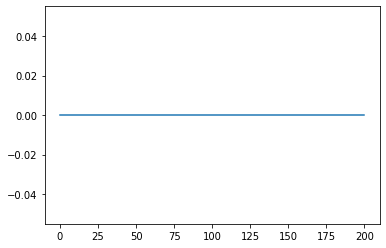

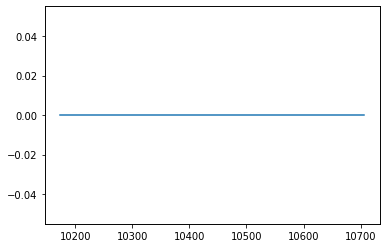

In [45]:
all_exc_frs = {}
all_exc_spikes = []
valid_gids = []
start_time = time_for_single_lap * (saved_weight_nlaps-1) + 500
end_time   = time_for_single_lap * saved_weight_nlaps + 500

#for i in circuit.neurons[0].keys():
for gid in place_cells:
    exc_spikes = cell_spike_times[gid]

    time_idxs = np.where( (exc_spikes >= start_time) & (exc_spikes <= end_time))[0]
    exc_spikes = exc_spikes[time_idxs]
    all_exc_spikes.append(exc_spikes)
    step = 12.5 # ms
    estimated_times = np.arange(start_time, end_time, step=step)
    if len(exc_spikes) == 0:
        all_exc_frs[gid] = np.zeros_like(estimated_times)
    else:
        estimated_fr,_ = baks(exc_spikes/1000., estimated_times/1000., a=10.0) # 1.75?
        all_exc_frs[gid] = estimated_fr
        valid_gids.append(gid)

all_exc_frs_array = np.vstack([ exc_frs for exc_frs in all_exc_frs.values() ])

idx = 167
plt.figure()
#plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs[valid_gids[idx]])
plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs_array[idx])

fig, ax = plt.subplots()
ax.plot(estimated_times/step, all_exc_frs_array[idx])
ax2 = ax.twinx()
#ax2.vlines(all_exc_spikes[valid_gids[idx]]/step, 0.5, 1.5)
ax2.vlines(all_exc_spikes[idx]/step, 0.5, 1.5)

ax2.set_ylim([0, 5])
ax2.set_yticks([])
plt.show();


20.625959882395132306 13.322466306895951021


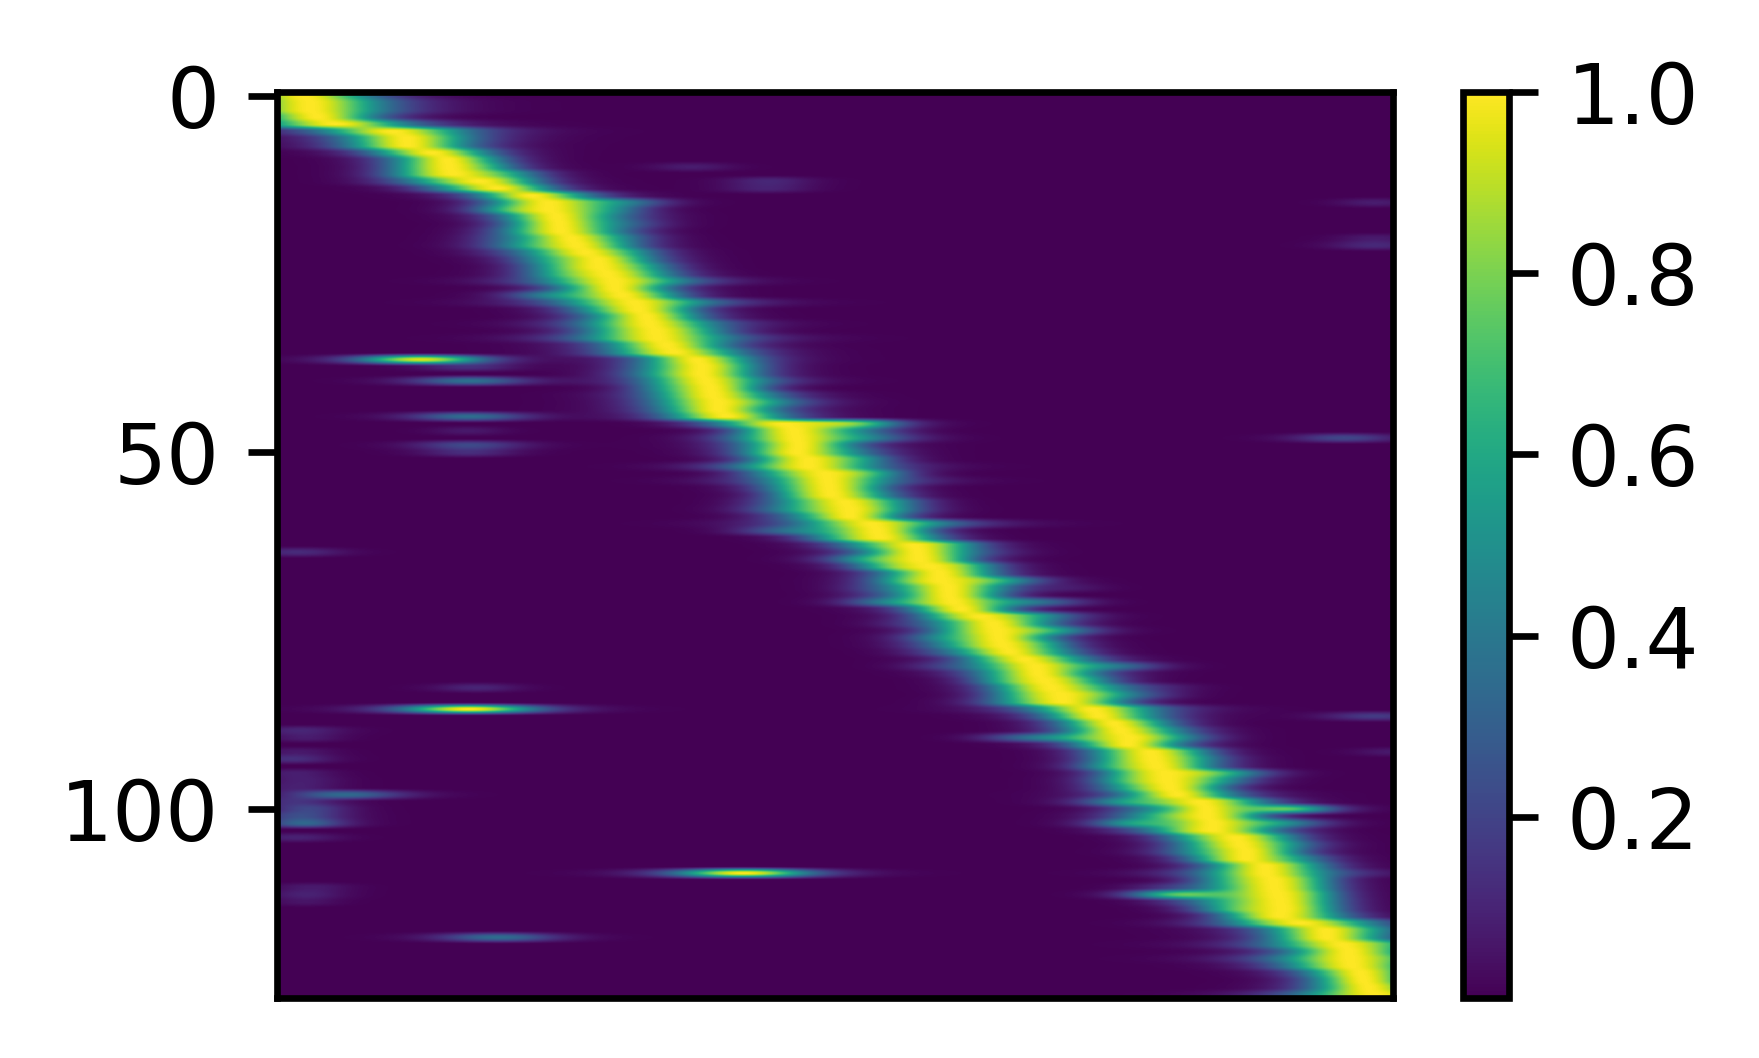

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


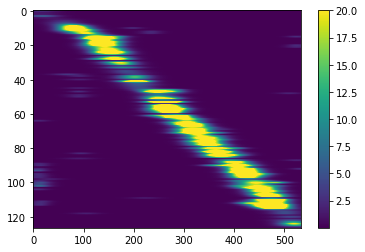

{0, 1, 2}


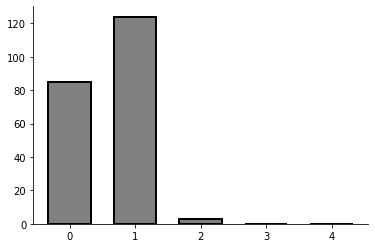

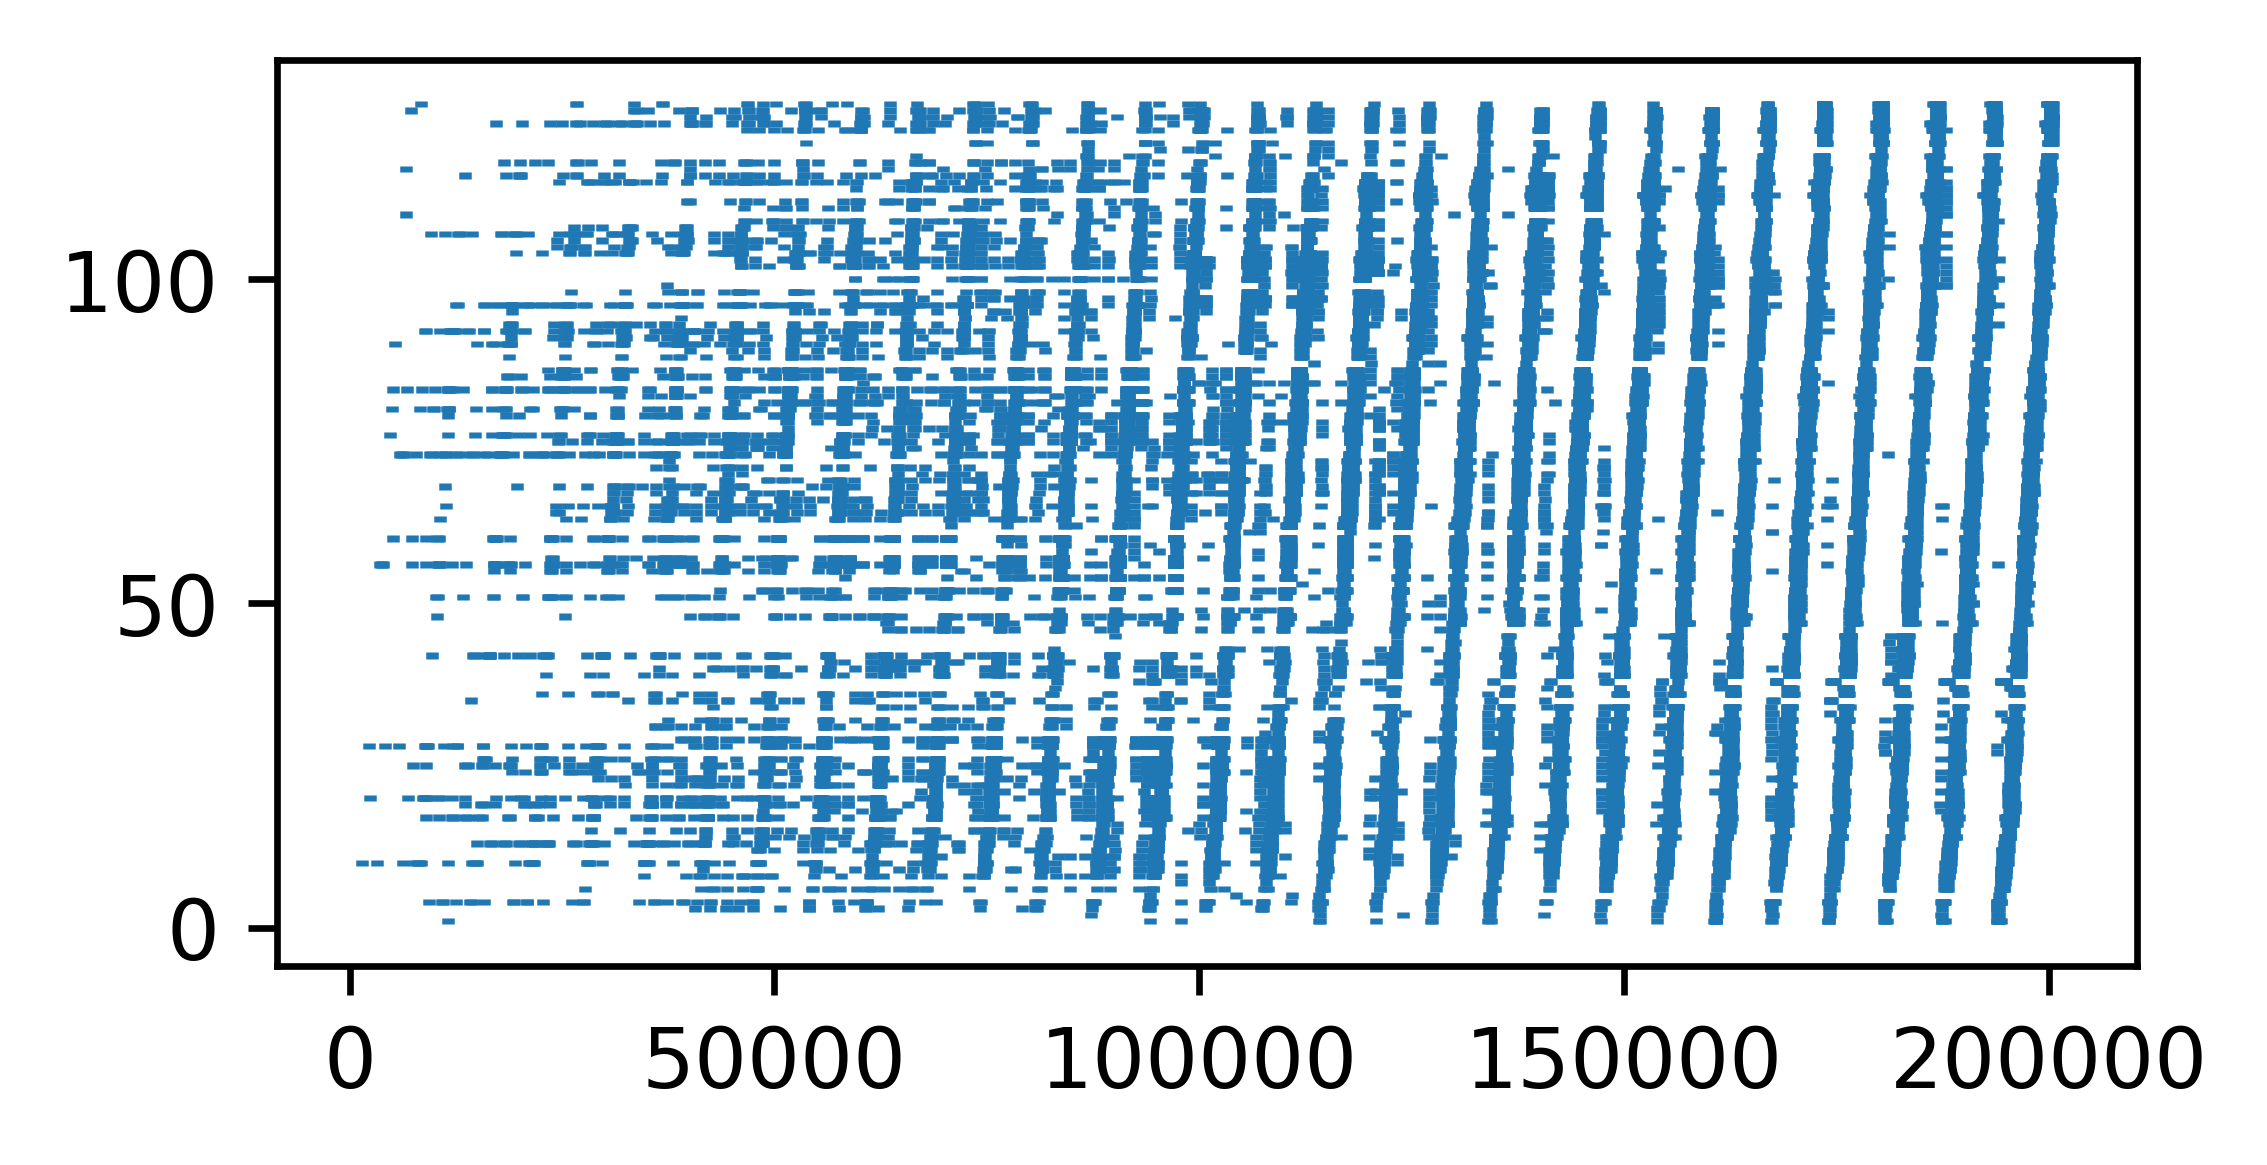

In [46]:


# valid_idxs = []
# invalid_idxs = []
# for i in range(len(all_exc_frs)):
#     sl = all_exc_frs[i]
#     if not np.all(sl < 10.0): valid_idxs.append(i)
#     else: 
#         invalid_idxs.append(i)

#valid_idxs = diagram.place_information[0]['place']#np.asarray(valid_gids)[np.asarray(valid_idxs)][sorted_max]
#valid_exc_frs = all_exc_frs[valid_idxs,:] # flip a rooni
valid_exc_frs = np.vstack([all_exc_frs[valid_gid] for valid_gid in valid_gids])
max_frs = valid_exc_frs.max(axis=1)
print(max_frs.mean(), max_frs.std())


normed = []
for i in range(len(valid_exc_frs)):
    normed.append(valid_exc_frs[i] / valid_exc_frs[i].max())
normed = np.asarray(normed, dtype='float32')

whereismax = []
for i in range(len(normed)):
    sl = normed[i,:]
    whereismax.append(sl.argmax())
sorted_max = np.argsort(whereismax)

normed_sorted        = normed[sorted_max,:]
valid_exc_frs_sorted = valid_exc_frs[sorted_max,:]


plt.figure(figsize=(3,2), dpi=600)
plt.imshow(normed_sorted, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xticks([])
plt.show()

plt.figure()
plt.imshow(valid_exc_frs_sorted, cmap='viridis', aspect='auto', vmax=20)
plt.colorbar()
plt.show()





# fig, ax = plt.subplots(5, 5, figsize=(12,8))
# for i in range(25):
#     xx = int(i/5)
#     yy = int(i%5)
#     ax[xx,yy].plot(estimated_times, normed_sorted[i])
#     ax[xx,yy].hlines(0.80, estimated_times[0], estimated_times[-1], linestyle='--')
#     ax[xx,yy].set_title(i)
    
ncrossed = []
for i in range(len(valid_exc_frs_sorted)):
    sl = normed_sorted[i]
    crossed = False
    ticks = 0
    for s in sl:
        if s > 0.80 and not crossed: 
            crossed = True
            ticks += 1
        if s <= 0.80 and crossed:
            crossed = False
    ncrossed.append(ticks)

ncrossed = np.asarray(ncrossed + [0 for _ in range(len(all_exc_frs) - len(valid_exc_frs))])
print(set(ncrossed))
fig = plt.figure()
ax = fig.gca()
plt.hist(ncrossed, bins=[0,1,2,3,4,5], align='left', rwidth=0.65, 
         edgecolor='k', color='gray', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

valid_raster = []
for nid in np.asarray(valid_gids)[sorted_max]:
    valid_raster.append(cell_spike_times[nid])

plt.figure(figsize=(4,2), dpi=600)
for (i,sts) in enumerate(valid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()



place median 0.0015207472
nonplace median 0.0023800002
-2.849462468551282 0.0043965391434903954


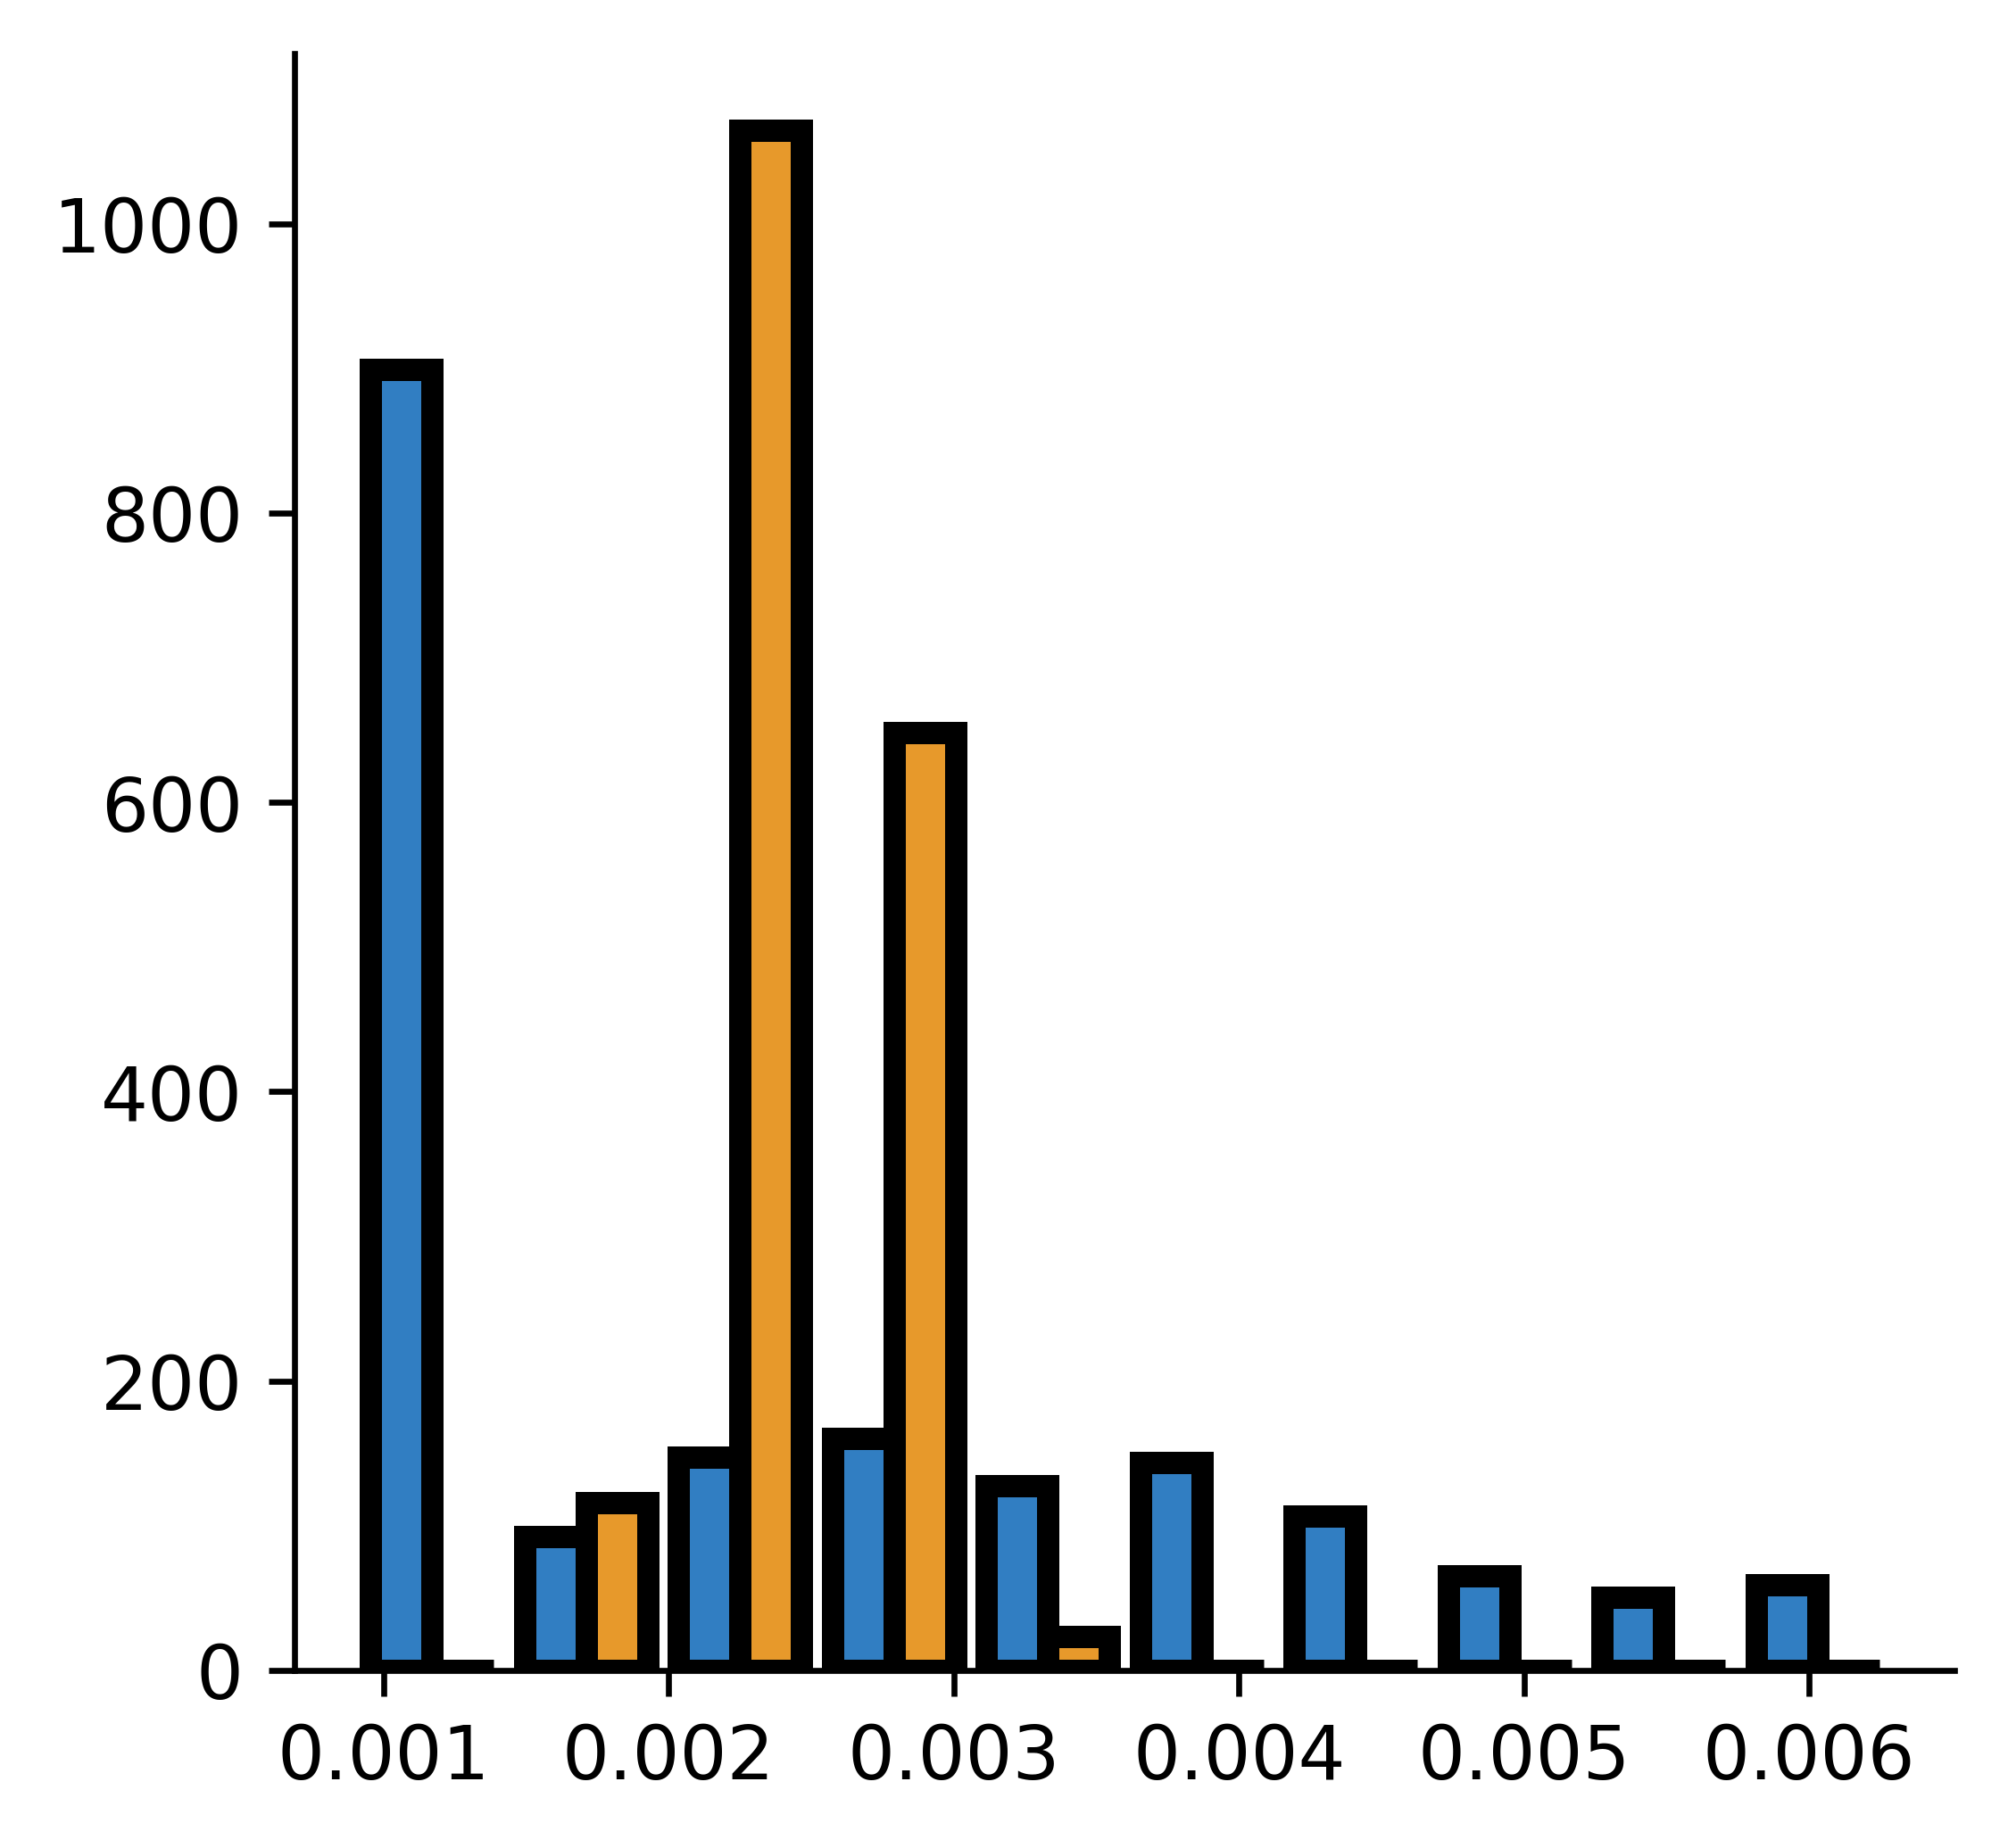

In [50]:
fig = plt.figure(figsize=(4,4),dpi=600)
ax  = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=[(49/255.,126/255.,194/255.), (231/255.,135/225.,43/255.)], 
         density=True, edgecolor='k', linewidth=3)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)